In [3]:
# see pre requisites here: https://github.com/pytorch/ios-demo-app/tree/master/ImageSegmentation
# see torchvision version compatibility here: https://pytorch.org/get-started/previous-versions/

# !pip uninstall torch torchvision torchdata torchtext -y
!pip install torch==1.13.0 torchvision==0.14.0 torchaudio==0.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu118
    Uninstalling torchvision-0.16.0+cu118:
      Successfully uninstalled torchvision-0.16.0+cu118
  Attempting uninstall: torchaudio
    Found existing installation: to

In [1]:
import torch
import torchvision
print("pytorch version: ", torch.__version__)
print("torchvision version: ", torchvision.__version__)
!python --version

pytorch version:  1.13.0+cu117
torchvision version:  0.14.0+cu117
Python 3.10.12


In [2]:
# reference: https://github.com/pytorch/vision/tree/main/references/segmentation

# prepare the run dir with right folder structure

!ln -s /content/drive/MyDrive/DeeplabV3-seg-train/coco_utils.py ./
!ln -s /content/drive/MyDrive/DeeplabV3-seg-train/transforms.py ./
!ln -s /content/drive/MyDrive/DeeplabV3-seg-train/presets.py ./
!ln -s /content/drive/MyDrive/DeeplabV3-seg-train/deeplab_utils.py ./
!ln -s /content/drive/MyDrive/DeeplabV3-seg-train/v2_extras.py ./

!ln -s /content/drive/MyDrive/Colab\ Notebooks/Mobile-Unet/utils ./

!ln -s /content/drive/MyDrive/OkraInsight/training_data ./
!ln -s /content/drive/MyDrive/OkraInsight/.ipynb_checkpoints ./

import importlib.util
wandb_check = importlib.util.find_spec("wandb")
have_wandb = wandb_check is not None
if not have_wandb:
  !pip install wandb


coremltools_check = importlib.util.find_spec("coremltools")
have_coremltools = coremltools_check is not None
if not have_coremltools:
  !pip install coremltools
  !python3 convert-script.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 30.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=1dc162f53185e7e42d5a7f71093cbfba90ffdcbc3221ff5de481ddf1e59363de
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 8.3 MB/s eta 0:00:00
python3: can't open file '/content/convert-script.py': [Errno 2] No such file or directory


In [3]:
import argparse
import logging
import sys
import wandb
import glob
import cv2
import pickle

import datetime
import os
import time
import warnings

import presets
import torch
import torch.utils.data
import torchvision
import deeplab_utils
import random

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import coremltools as ct

from pathlib import Path
from torch import optim
from tqdm import tqdm
from coco_utils import get_coco

from torch.optim.lr_scheduler import PolynomialLR
from torchvision.transforms import functional as TF, InterpolationMode
from torch.utils.data import DataLoader, random_split

from utils.data_loading import BasicDataset, OkraDataset, OkraAugmentedDataset
from utils.dice_score import dice_loss

In [6]:
def get_okra(root, image_set, transforms, use_v2=False):
  print(root)
  #img_folder = os.path.join(root, '/images/class_okraSurface')
  #mask_folder = os.path.join(root, '/masks')
  img_folder = './training_data/okra_images/class_okra_surface'
  mask_folder ='./training_data/okra_segmentation_target_masks'
  img_scale = 0.1

  # normalize = torchvision.transforms.Normalize(mean=[0.25, 0.2, 0.406], std=[0.129, 0.124, 0.225])

  normalize = torchvision.transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])

  dataset_l2rUp = OkraDataset(img_folder, mask_folder, normalize, img_scale, 0)
  dataset_r2lUp = OkraDataset(img_folder, mask_folder, normalize, img_scale, 1)
  dataset_l2rDn = OkraDataset(img_folder, mask_folder, normalize, img_scale, 2)
  dataset_r2lDn = OkraDataset(img_folder, mask_folder, normalize, img_scale, 3)

  return OkraAugmentedDataset([dataset_l2rUp, dataset_r2lUp, dataset_l2rDn, dataset_r2lDn])

  #return OkraDataset(img_folder, mask_folder, 0.1)

def get_dataset(args, is_train):
    def sbd(*args, **kwargs):
        kwargs.pop("use_v2")
        return torchvision.datasets.SBDataset(*args, mode="segmentation", **kwargs)

    def voc(*args, **kwargs):
        kwargs.pop("use_v2")
        return torchvision.datasets.VOCSegmentation(*args, **kwargs)

    paths = {
        "voc": (args.data_path, voc, 21),
        "voc_aug": (args.data_path, sbd, 21),
        "coco": (args.data_path, get_coco, 21),
        "okra":(args.data_path, get_okra, 1),
    }
    p, ds_fn, num_classes = paths[args.dataset]

    image_set = "train" if is_train else "val"
    ds = ds_fn(p, image_set=image_set, transforms=get_transform(is_train, args), use_v2=args.use_v2)

    # 2. Split into train / validation partitions
    val_percent = 0.1
    n_val = int(len(ds) * val_percent)
    n_train = len(ds) - n_val
    train_set, val_set = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(0))
    # print("n_val = ", n_val, ", n_train = ", n_train)
    if is_train:
      return train_set, num_classes
    else:
      return val_set, num_classes


def get_transform(is_train, args):
    if is_train:
        return presets.SegmentationPresetTrain(base_size=520, crop_size=480, backend=args.backend, use_v2=args.use_v2)
    elif args.weights and args.test_only:
        weights = torchvision.models.get_weight(args.weights)
        trans = weights.transforms()

        def preprocessing(img, target):
            img = trans(img)
            size = F.get_dimensions(img)[1:]
            target = F.resize(target, size, interpolation=InterpolationMode.NEAREST)
            return img, F.pil_to_tensor(target)

        return preprocessing
    else:
        return presets.SegmentationPresetEval(base_size=520, backend=args.backend, use_v2=args.use_v2)


def criterion(inputs, target):
    losses = {}
    #loss_fn=nn.functional.cross_entropy()
    #loss_fn = nn.MSELoss()
    loss_fn = nn.BCEWithLogitsLoss()
    for name, x in inputs.items():
      losses[name] = loss_fn(x.squeeze(1), target.float())
      losses[name] += dice_loss(F.sigmoid(x.squeeze(1)), target.float(), multiclass=False)
    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]


def evaluate(model, data_loader, device, num_classes):
    model.eval()
    confmat = deeplab_utils.ConfusionMatrix(num_classes)
    metric_logger = deeplab_utils.MetricLogger(delimiter="  ")
    header = "Test:"
    num_processed_samples = 0
    with torch.inference_mode():
        for image_target in metric_logger.log_every(data_loader, 100, header):
            image, target = image_target['image'].to(device), image_target['mask'].to(device)
            output = model(image)
            output = output["out"]

            confmat.update(target.flatten(), output.argmax(1).flatten())
            # FIXME need to take into account that the datasets
            # could have been padded in distributed setup
            num_processed_samples += image.shape[0]

        confmat.reduce_from_all_processes()

    num_processed_samples = deeplab_utils.reduce_across_processes(num_processed_samples)
    if (
        hasattr(data_loader.dataset, "__len__")
        and len(data_loader.dataset) != num_processed_samples
        and torch.distributed.get_rank() == 0
    ):
        # See FIXME above
        warnings.warn(
            f"It looks like the dataset has {len(data_loader.dataset)} samples, but {num_processed_samples} "
            "samples were used for the validation, which might bias the results. "
            "Try adjusting the batch size and / or the world size. "
            "Setting the world size to 1 is always a safe bet."
        )

    return confmat

def train_one_epoch(experiment, model, batch_size, global_step, criterion, optimizer, data_loader, lr_scheduler, device, epoch, epochs, print_freq, scaler=None):
  model.train()
  epoch_loss = 0
  with tqdm(total=len(data_loader.dataset), desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
    metric_logger = deeplab_utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", deeplab_utils.SmoothedValue(window_size=1, fmt="{value}"))
    header = f"Epoch: [{epoch}]"
    for image_target in metric_logger.log_every(data_loader, print_freq, header):
        image, target = image_target['image'].to(device), image_target['mask'].to(device)
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            output = model(image)
            loss = criterion(output, target)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        lr_scheduler.step()
        pbar.update(image.shape[0])
        global_step += 1
        epoch_loss += loss.item()
        experiment.log({
          'train loss': loss.item(),
          'step': global_step,
          'epoch': epoch
        })
        pbar.set_postfix(**{'loss (batch)': loss.item()})
        metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])

        # Evaluation round
        division_step = (len(data_loader.dataset) // (1 * batch_size))
        if division_step > 0:
          if global_step % division_step == 0:
            histograms = {}
            for tag, value in model.named_parameters():
              tag = tag.replace('/', '.')
              if not (torch.isinf(value) | torch.isnan(value)).any():
                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
              if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

            try:
              experiment.log({
                            'learning rate': optimizer.param_groups[0]['lr'],
                            'images': wandb.Image(image.cpu()),
                            'masks': {
                                'true': wandb.Image(target.float().cpu()),
                                'pred': wandb.Image(output['out'].argmax(dim=1)[0].float().cpu()),
                            },
                            'step': global_step,
                            'epoch': epoch,
                            **histograms
                            })
            except:
              pass
  return global_step

In [7]:
import argparse
from torch.utils.mobile_optimizer import optimize_for_mobile

def main(args):
    if args.backend.lower() != "pil" and not args.use_v2:
        # TODO: Support tensor backend in V1?
        raise ValueError("Use --use-v2 if you want to use the tv_tensor or tensor backend.")
    if args.use_v2 and args.dataset != "coco":
        raise ValueError("v2 is only support supported for coco dataset for now.")

    if args.output_dir:
        deeplab_utils.mkdir(args.output_dir)

    deeplab_utils.init_distributed_mode(args)
    print(args)

    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
      dict(epochs=args.epochs, batch_size=args.batch_size, learning_rate=args.lr,
        val_percent=0.1, amp=args.amp)
    )

    device = torch.device(args.device)

    if args.use_deterministic_algorithms:
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True)
    else:
        torch.backends.cudnn.benchmark = True

    dataset, num_classes = get_dataset(args, is_train=True)
    dataset_test, _ = get_dataset(args, is_train=False)
    n_train = len(dataset)
    n_val = len(dataset_test)
    logging.info(f'''Starting training:
      Epochs:          {args.epochs}
      Batch size:      {args.batch_size}
      Learning rate:   {args.lr}
      Training size:   {n_train}
      Validation size: {n_val}
      Device:          {args.device}
      Mixed Precision: {args.amp}
    ''')

    if args.distributed:
        train_sampler = torch.utils.data.distributed.DistributedSampler(dataset)
        test_sampler = torch.utils.data.distributed.DistributedSampler(dataset_test, shuffle=False)
    else:
        train_sampler = torch.utils.data.RandomSampler(dataset)
        test_sampler = torch.utils.data.SequentialSampler(dataset_test)

    #collate_fn=utils.collate_fn,
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=args.batch_size,
        sampler=train_sampler,
        num_workers=args.workers,
        drop_last=True,
    )

    #, collate_fn=utils.collate_fn
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, sampler=test_sampler, num_workers=args.workers
    )

    # model = torch.hub.load('pytorch/vision:v0.14.0', 'deeplabv3_mobilenet_v3_large', progress=True, pretrained=False, num_classes=num_classes)


    model = torchvision.models.get_model(
        args.model,
        weights=args.weights,
        weights_backbone=args.weights_backbone,
        num_classes=num_classes,
        aux_loss=args.aux_loss,
        pretrained=True,
        width_mult=1.0,
        reduced_tail=False,
        dilated=False
    )

    model.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(960, num_classes)

    model.to(device)
    if args.distributed:
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)

    model_without_ddp = model
    if args.distributed:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
        model_without_ddp = model.module

    params_to_optimize = [
        {"params": [p for p in model_without_ddp.backbone.parameters() if p.requires_grad]},
        {"params": [p for p in model_without_ddp.classifier.parameters() if p.requires_grad]},
    ]
    if args.aux_loss:
        params = [p for p in model_without_ddp.aux_classifier.parameters() if p.requires_grad]
        params_to_optimize.append({"params": params, "lr": args.lr * 10})
    optimizer = torch.optim.SGD(params_to_optimize, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    scaler = torch.cuda.amp.GradScaler() if args.amp else None

    iters_per_epoch = len(data_loader)
    main_lr_scheduler = PolynomialLR(
        optimizer, total_iters=iters_per_epoch * (args.epochs - args.lr_warmup_epochs), power=0.9
    )

    if args.lr_warmup_epochs > 0:
        warmup_iters = iters_per_epoch * args.lr_warmup_epochs
        args.lr_warmup_method = args.lr_warmup_method.lower()
        if args.lr_warmup_method == "linear":
            warmup_lr_scheduler = torch.optim.lr_scheduler.LinearLR(
                optimizer, start_factor=args.lr_warmup_decay, total_iters=warmup_iters
            )
        elif args.lr_warmup_method == "constant":
            warmup_lr_scheduler = torch.optim.lr_scheduler.ConstantLR(
                optimizer, factor=args.lr_warmup_decay, total_iters=warmup_iters
            )
        else:
            raise RuntimeError(
                f"Invalid warmup lr method '{args.lr_warmup_method}'. Only linear and constant are supported."
            )
        lr_scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer, schedulers=[warmup_lr_scheduler, main_lr_scheduler], milestones=[warmup_iters]
        )
    else:
        lr_scheduler = main_lr_scheduler

    if args.resume:
        checkpoint = torch.load(args.resume, map_location="cpu")
        model_without_ddp.load_state_dict(checkpoint["model"], strict=not args.test_only)
        if not args.test_only:
            optimizer.load_state_dict(checkpoint["optimizer"])
            lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
            args.start_epoch = checkpoint["epoch"] + 1
            if args.amp:
                scaler.load_state_dict(checkpoint["scaler"])

    if args.test_only:
        # We disable the cudnn benchmarking because it can noticeably affect the accuracy
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        confmat = evaluate(model, data_loader_test, device=device, num_classes=num_classes)
        print(confmat)
        return

    start_time = time.time()
    global_step = 0
    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            train_sampler.set_epoch(epoch)
        global_step += train_one_epoch(experiment, model, args.batch_size, global_step, criterion, optimizer, data_loader, lr_scheduler, device, epoch, args.epochs, args.print_freq, scaler)

        # Evaluation round
        division_step = (n_train // (1 * args.batch_size))
        if division_step > 0:
          if global_step % division_step == 0:
            histograms = {}
            for tag, value in model.named_parameters():
              tag = tag.replace('/', '.')
              if not (torch.isinf(value) | torch.isnan(value)).any():
                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
              if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

            confmat = evaluate(model, data_loader_test, device=device, num_classes=num_classes)

            logging.info('Validation Dice score: {}'.format(confmat))

        # print(confmat)
        if ((epoch %25) == 0 and epoch > 0):
          checkpoint = {
            "model": model_without_ddp.state_dict(),
            "optimizer": optimizer.state_dict(),
            "lr_scheduler": lr_scheduler.state_dict(),
            "epoch": epoch,
            "args": args,
          }
          if args.amp:
            checkpoint["scaler"] = scaler.state_dict()

          deeplab_utils.save_on_master(checkpoint, os.path.join(args.output_dir, f"model_{epoch}.pth"))
            # utils.save_on_master(checkpoint, os.path.join(args.output_dir, "checkpoint.pth"))

    model.to(torch.device('cpu'))
    traceable_model = model.eval()

    scriptedm = torch.jit.script(traceable_model)

    scriptedm.save(".ipynb_checkpoints/deeplabv3_mobilenet_normalized.pt")

    #optimized_model = optimize_for_mobile(scriptedm)
    #optimized_model.save(".ipynb_checkpoints/deeplabv3_scripted_wt_opt.pt")
    # optimized_model._save_for_lite_interpreter(".ipynb_checkpoints/deeplabv3_scripted_opt_lite.pt")
    #torch.jit.save(scriptedm, '.ipynb_checkpoints/deeplabv3_scripted.pt')
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print(f"Training time {total_time_str}")


def get_args_parser(add_help=True):
    import argparse
    from torchvision.models import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights

    parser = argparse.ArgumentParser(description="PyTorch Segmentation Training", add_help=add_help)

    parser.add_argument("--data_path", default="/datasets01/COCO/022719/", type=str, help="dataset path")
    parser.add_argument("--dataset", default="coco", type=str, help="dataset name")
    parser.add_argument("--model", default="fcn_resnet101", type=str, help="model name")
    parser.add_argument("--aux-loss", action="store_true", help="auxiliary loss")
    parser.add_argument("--device", default="cuda", type=str, help="device (Use cuda or cpu Default: cuda)")
    parser.add_argument(
        "-b", "--batch-size", default=8, type=int, help="images per gpu, the total batch size is $NGPU x batch_size"
    )
    parser.add_argument("--epochs", default=30, type=int, metavar="N", help="number of total epochs to run")

    parser.add_argument(
        "-j", "--workers", default=16, type=int, metavar="N", help="number of data loading workers (default: 16)"
    )
    parser.add_argument("--lr", default=0.01, type=float, help="initial learning rate")
    parser.add_argument("--momentum", default=0.9, type=float, metavar="M", help="momentum")
    parser.add_argument(
        "--wd",
        "--weight-decay",
        default=1e-4,
        type=float,
        metavar="W",
        help="weight decay (default: 1e-4)",
        dest="weight_decay",
    )
    parser.add_argument("--lr-warmup-epochs", default=0, type=int, help="the number of epochs to warmup (default: 0)")
    parser.add_argument("--lr-warmup-method", default="linear", type=str, help="the warmup method (default: linear)")
    parser.add_argument("--lr-warmup-decay", default=0.01, type=float, help="the decay for lr")
    parser.add_argument("--print-freq", default=10, type=int, help="print frequency")
    parser.add_argument("--output-dir", default=".", type=str, help="path to save outputs")
    parser.add_argument("--resume", default="", type=str, help="path of checkpoint")
    parser.add_argument("--start-epoch", default=0, type=int, metavar="N", help="start epoch")
    parser.add_argument(
        "--test-only",
        dest="test_only",
        help="Only test the model",
        action="store_true",
    )
    parser.add_argument(
        "--use-deterministic-algorithms", action="store_true", help="Forces the use of deterministic algorithms only."
    )
    # distributed training parameters
    parser.add_argument("--world-size", default=1, type=int, help="number of distributed processes")
    parser.add_argument("--dist-url", default="env://", type=str, help="url used to set up distributed training")

    parser.add_argument("--weights", default=None, type=str, help="the weights enum name to load")
    parser.add_argument("--weights-backbone", default=None, type=str, help="the backbone weights enum name to load")

    # Mixed precision training parameters
    parser.add_argument("--amp", action="store_true", help="Use torch.cuda.amp for mixed precision training")

    parser.add_argument("--backend", default="PIL", type=str.lower, help="PIL or tensor - case insensitive")
    parser.add_argument("--use-v2", action="store_true", help="Use V2 transforms")
    return parser

# model='deeplabv3_mobilenet_v3_large'
# model='deeplabv3_resnet101'
if __name__ == "__main__":
  class Args(argparse.Namespace):
    nproc_per_node =8
    dataset='okra'
    b=4
    model='deeplabv3_mobilenet_v3_large'
    wd = 0.000001
    backend='pil'
    data_path = './data'
    use_v2=False
    output_dir='./'
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
    use_deterministic_algorithms=False
    image_set='train'
    weights=None
    weights_backbone='DEFAULT'
    batch_size=3
    workers=os.cpu_count()
    aux_loss=None
    lr=0.02
    momentum=0.499
    weight_decay=1e-8
    amp=None
    epochs=50
    lr_warmup_epochs=0
    resume=None
    test_only=None
    start_epoch=0
    print_freq=10



  args=Args()

  # args = get_args_parser().parse_args()
  main(args)

Not using distributed mode
Args(distributed=False)


./data


100%|██████████| 31/31 [00:13<00:00,  2.31it/s]

./data



100%|██████████| 31/31 [00:15<00:00,  2.00it/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

Epoch 0/50:   0%|          | 0/112 [00:00<?, ?img/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0/50:   5%|▌         | 6/112 [00:19<04:50,  2.74s/img, loss (batch)=1.57]

Epoch: [0]  [ 0/37]  eta: 0:12:12  lr: 0.01999027000725247  loss: 1.7255 (1.7255)  time: 19.7899  data: 7.6694  max mem: 3218


Epoch 0/50:  29%|██▉       | 33/112 [00:41<01:23,  1.06s/img, loss (batch)=0.926]

Epoch: [0]  [10/37]  eta: 0:01:41  lr: 0.019892941084538932  loss: 1.2076 (1.2328)  time: 3.7533  data: 2.5427  max mem: 3218


Epoch 0/50:  56%|█████▋    | 63/112 [01:01<00:32,  1.53img/s, loss (batch)=0.5]  

Epoch: [0]  [20/37]  eta: 0:00:49  lr: 0.019795559222241986  loss: 0.8745 (0.9582)  time: 2.0734  data: 1.9507  max mem: 3218


Epoch 0/50:  86%|████████▌ | 96/112 [01:19<00:07,  2.24img/s, loss (batch)=0.373]

Epoch: [0]  [30/37]  eta: 0:00:18  lr: 0.019698124101881355  loss: 0.4918 (0.8268)  time: 1.9274  data: 1.7846  max mem: 3218


Epoch 0/50:  99%|█████████▉| 111/112 [01:31<00:00,  1.21img/s, loss (batch)=0.277]

Epoch: [0] Total time: 0:01:31


Test:  [ 0/12]  eta: 0:00:27    time: 2.2844  data: 1.7345  max mem: 3218


/content/deeplab_utils.py:295: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(val)


Test: Total time: 0:00:06


Epoch 1/50:   5%|▌         | 6/112 [00:06<01:35,  1.10img/s, loss (batch)=0.275]

Epoch: [1]  [ 0/37]  eta: 0:03:54  lr: 0.019629887656714914  loss: 0.3432 (0.3432)  time: 6.3423  data: 6.1685  max mem: 3218


Epoch 1/50:  29%|██▉       | 33/112 [00:25<01:05,  1.21img/s, loss (batch)=0.237]

Epoch: [1]  [10/37]  eta: 0:01:03  lr: 0.01953236125629242  loss: 0.2657 (0.2778)  time: 2.3476  data: 2.1924  max mem: 3218


Epoch 1/50:  56%|█████▋    | 63/112 [00:42<00:33,  1.46img/s, loss (batch)=0.235]

Epoch: [1]  [20/37]  eta: 0:00:34  lr: 0.019434780719359418  loss: 0.2397 (0.3436)  time: 1.8033  data: 1.6486  max mem: 3218


Epoch 1/50:  83%|████████▎ | 93/112 [00:57<00:11,  1.63img/s, loss (batch)=0.334]

Epoch: [1]  [30/37]  eta: 0:00:13  lr: 0.01933714571350856  loss: 0.2397 (0.4316)  time: 1.5974  data: 1.4475  max mem: 3218


Epoch 1/50:  99%|█████████▉| 111/112 [01:06<00:00,  1.66img/s, loss (batch)=0.239]

Epoch: [1] Total time: 0:01:06


Test:  [ 0/12]  eta: 0:00:13    time: 1.1593  data: 1.1119  max mem: 3218
Test: Total time: 0:00:08


Epoch 2/50:   5%|▌         | 6/112 [00:04<00:59,  1.77img/s, loss (batch)=0.26]

Epoch: [2]  [ 0/37]  eta: 0:02:25  lr: 0.0192687686204638  loss: 1.7728 (1.7728)  time: 3.9234  data: 3.7328  max mem: 3218


Epoch 2/50:  29%|██▉       | 33/112 [00:19<00:57,  1.37img/s, loss (batch)=0.232]

Epoch: [2]  [10/37]  eta: 0:00:48  lr: 0.01917104024345274  loss: 0.2719 (0.4694)  time: 1.7864  data: 1.6260  max mem: 3218


Epoch 2/50:  59%|█████▉    | 66/112 [00:36<00:24,  1.87img/s, loss (batch)=0.253]

Epoch: [2]  [20/37]  eta: 0:00:29  lr: 0.019073256480256602  loss: 0.2558 (0.4022)  time: 1.6013  data: 1.4341  max mem: 3218


Epoch 2/50:  83%|████████▎ | 93/112 [00:51<00:12,  1.48img/s, loss (batch)=0.181]

Epoch: [2]  [30/37]  eta: 0:00:11  lr: 0.01897541698362285  loss: 0.2088 (0.3379)  time: 1.5869  data: 1.4221  max mem: 3218


Epoch 2/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.83img/s, loss (batch)=0.191]

Epoch: [2] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:14    time: 1.2216  data: 1.1535  max mem: 3218
Test: Total time: 0:00:06


Epoch 3/50:   5%|▌         | 6/112 [00:04<01:08,  1.54img/s, loss (batch)=0.173]

Epoch: [3]  [ 0/37]  eta: 0:02:49  lr: 0.018906895986561683  loss: 0.1956 (0.1956)  time: 4.5839  data: 4.4418  max mem: 3218


Epoch 3/50:  29%|██▉       | 33/112 [00:19<00:53,  1.49img/s, loss (batch)=0.144]

Epoch: [3]  [10/37]  eta: 0:00:47  lr: 0.018808960934270275  loss: 0.1689 (0.1729)  time: 1.7724  data: 1.6149  max mem: 3218


Epoch 3/50:  59%|█████▉    | 66/112 [00:34<00:19,  2.37img/s, loss (batch)=0.164]

Epoch: [3]  [20/37]  eta: 0:00:27  lr: 0.018710969189866734  loss: 0.1689 (0.2566)  time: 1.4659  data: 1.3067  max mem: 3218


Epoch 3/50:  83%|████████▎ | 93/112 [00:49<00:09,  1.94img/s, loss (batch)=0.164]

Epoch: [3]  [30/37]  eta: 0:00:11  lr: 0.018612920390253404  loss: 0.1683 (0.2325)  time: 1.4800  data: 1.3143  max mem: 3218


Epoch 3/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.86img/s, loss (batch)=0.303]

Epoch: [3] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:14    time: 1.1753  data: 1.1302  max mem: 3218
Test: Total time: 0:00:05


Epoch 4/50:   3%|▎         | 3/112 [00:05<03:12,  1.77s/img, loss (batch)=0.166]

Epoch: [4]  [ 0/37]  eta: 0:03:17  lr: 0.018544252086025833  loss: 0.1659 (0.1659)  time: 5.3385  data: 5.0557  max mem: 3218


Epoch 4/50:  29%|██▉       | 33/112 [00:20<00:49,  1.58img/s, loss (batch)=0.148]

Epoch: [4]  [10/37]  eta: 0:00:49  lr: 0.01844610544656621  loss: 0.1807 (0.1933)  time: 1.8262  data: 1.6523  max mem: 3218


Epoch 4/50:  56%|█████▋    | 63/112 [00:34<00:24,  2.04img/s, loss (batch)=0.161]

Epoch: [4]  [20/37]  eta: 0:00:27  lr: 0.01834790074899512  loss: 0.1600 (0.2267)  time: 1.4569  data: 1.2947  max mem: 3218


Epoch 4/50:  83%|████████▎ | 93/112 [00:49<00:09,  2.04img/s, loss (batch)=0.25] 

Epoch: [4]  [30/37]  eta: 0:00:11  lr: 0.01824963761327881  loss: 0.1608 (0.2363)  time: 1.4931  data: 1.3379  max mem: 3218


Epoch 4/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.83img/s, loss (batch)=0.192]

Epoch: [4] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:14    time: 1.2229  data: 1.1595  max mem: 3218
Test: Total time: 0:00:05


Epoch 5/50:   3%|▎         | 3/112 [00:03<01:50,  1.01s/img, loss (batch)=0.215]

Epoch: [5]  [ 0/37]  eta: 0:01:53  lr: 0.018180818441709063  loss: 0.2151 (0.2151)  time: 3.0608  data: 2.7659  max mem: 3218


Epoch 5/50:  32%|███▏      | 36/112 [00:18<00:28,  2.70img/s, loss (batch)=0.197]

Epoch: [5]  [10/37]  eta: 0:00:45  lr: 0.018082455075401516  loss: 0.2506 (0.3359)  time: 1.6931  data: 1.5132  max mem: 3218


Epoch 5/50:  59%|█████▉    | 66/112 [00:35<00:17,  2.59img/s, loss (batch)=0.162]

Epoch: [5]  [20/37]  eta: 0:00:28  lr: 0.01798403222074034  loss: 0.1961 (0.2985)  time: 1.5954  data: 1.4200  max mem: 3218


Epoch 5/50:  86%|████████▌ | 96/112 [00:50<00:06,  2.56img/s, loss (batch)=0.144]

Epoch: [5]  [30/37]  eta: 0:00:11  lr: 0.017885549479563126  loss: 0.1617 (0.2589)  time: 1.6064  data: 1.4305  max mem: 3218


Epoch 5/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.83img/s, loss (batch)=1.03]

Epoch: [5] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:13    time: 1.1632  data: 1.1180  max mem: 3218
Test: Total time: 0:00:05


Epoch 6/50:   5%|▌         | 6/112 [00:03<00:46,  2.28img/s, loss (batch)=0.241]

Epoch: [6]  [ 0/37]  eta: 0:01:48  lr: 0.01781657571251342  loss: 0.1984 (0.1984)  time: 2.9383  data: 2.7341  max mem: 3218


Epoch 6/50:  29%|██▉       | 33/112 [00:18<00:42,  1.88img/s, loss (batch)=0.183]

Epoch: [6]  [10/37]  eta: 0:00:46  lr: 0.017717990235939104  loss: 0.1765 (0.1755)  time: 1.7185  data: 1.5517  max mem: 3218


Epoch 6/50:  56%|█████▋    | 63/112 [00:34<00:25,  1.94img/s, loss (batch)=0.852]

Epoch: [6]  [20/37]  eta: 0:00:28  lr: 0.01761934377196394  loss: 0.1562 (0.1935)  time: 1.5847  data: 1.4194  max mem: 3218


Epoch 6/50:  83%|████████▎ | 93/112 [00:50<00:10,  1.80img/s, loss (batch)=0.13] 

Epoch: [6]  [30/37]  eta: 0:00:11  lr: 0.01752063590299065  loss: 0.1463 (0.1950)  time: 1.5967  data: 1.4192  max mem: 3218


Epoch 6/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.85img/s, loss (batch)=0.155]

Epoch: [6] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:22    time: 1.8863  data: 1.8211  max mem: 3218
Test: Total time: 0:00:06


Epoch 7/50:   5%|▌         | 6/112 [00:03<00:46,  2.27img/s, loss (batch)=0.132]

Epoch: [7]  [ 0/37]  eta: 0:01:48  lr: 0.017451503632394363  loss: 0.1322 (0.1322)  time: 2.9272  data: 2.7291  max mem: 3218


Epoch 7/50:  29%|██▉       | 33/112 [00:18<00:42,  1.87img/s, loss (batch)=0.316]

Epoch: [7]  [10/37]  eta: 0:00:46  lr: 0.01735269040093725  loss: 0.1885 (0.2261)  time: 1.7134  data: 1.5533  max mem: 3218


Epoch 7/50:  56%|█████▋    | 63/112 [00:34<00:25,  1.94img/s, loss (batch)=0.107]

Epoch: [7]  [20/37]  eta: 0:00:28  lr: 0.017253814609226203  loss: 0.1394 (0.1827)  time: 1.5835  data: 1.4224  max mem: 3218


Epoch 7/50:  83%|████████▎ | 93/112 [00:50<00:10,  1.83img/s, loss (batch)=0.125]

Epoch: [7]  [30/37]  eta: 0:00:11  lr: 0.017154875818795455  loss: 0.1266 (0.1909)  time: 1.5775  data: 1.4257  max mem: 3218


Epoch 7/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.88img/s, loss (batch)=0.151]

Epoch: [7] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:24    time: 2.0176  data: 1.9228  max mem: 3218
Test: Total time: 0:00:07


Epoch 8/50:   5%|▌         | 6/112 [00:03<00:44,  2.37img/s, loss (batch)=0.212]

Epoch: [8]  [ 0/37]  eta: 0:01:45  lr: 0.017085580943536075  loss: 0.4893 (0.4893)  time: 2.8576  data: 2.7138  max mem: 3218


Epoch 8/50:  32%|███▏      | 36/112 [00:18<00:31,  2.45img/s, loss (batch)=0.11] 

Epoch: [8]  [10/37]  eta: 0:00:46  lr: 0.016986534032231913  loss: 0.1525 (0.1936)  time: 1.7120  data: 1.5338  max mem: 3218


Epoch 8/50:  59%|█████▉    | 66/112 [00:35<00:20,  2.21img/s, loss (batch)=0.133]

Epoch: [8]  [20/37]  eta: 0:00:28  lr: 0.016887422908521844  loss: 0.1331 (0.1609)  time: 1.6193  data: 1.4423  max mem: 3218


Epoch 8/50:  86%|████████▌ | 96/112 [00:51<00:07,  2.17img/s, loss (batch)=0.106]

Epoch: [8]  [30/37]  eta: 0:00:11  lr: 0.016788247111494653  loss: 0.1262 (0.1513)  time: 1.6407  data: 1.4611  max mem: 3218


Epoch 8/50:  99%|█████████▉| 111/112 [00:58<00:00,  1.89img/s, loss (batch)=0.144]

Epoch: [8] Total time: 0:00:58


Test:  [ 0/12]  eta: 0:00:22    time: 1.8915  data: 1.8376  max mem: 3218
Test: Total time: 0:00:08


Epoch 9/50:   5%|▌         | 6/112 [00:02<00:44,  2.38img/s, loss (batch)=0.104]

Epoch: [9]  [ 0/37]  eta: 0:01:42  lr: 0.01671878532298871  loss: 0.1044 (0.1044)  time: 2.7677  data: 2.5850  max mem: 3218


Epoch 9/50:  29%|██▉       | 33/112 [00:18<00:48,  1.61img/s, loss (batch)=0.109]

Epoch: [9]  [10/37]  eta: 0:00:45  lr: 0.016619498505471758  loss: 0.1088 (0.1131)  time: 1.6931  data: 1.5340  max mem: 3218


Epoch 9/50:  59%|█████▉    | 66/112 [00:34<00:23,  1.95img/s, loss (batch)=0.109]

Epoch: [9]  [20/37]  eta: 0:00:28  lr: 0.016520145738050968  loss: 0.1168 (0.1252)  time: 1.5924  data: 1.4351  max mem: 3218


Epoch 9/50:  83%|████████▎ | 93/112 [00:49<00:12,  1.51img/s, loss (batch)=0.105] 

Epoch: [9]  [30/37]  eta: 0:00:11  lr: 0.01642072653563128  loss: 0.1168 (0.1242)  time: 1.5425  data: 1.3794  max mem: 3218


Epoch 9/50:  99%|█████████▉| 111/112 [00:58<00:00,  1.91img/s, loss (batch)=0.122]

Epoch: [9] Total time: 0:00:58


Test:  [ 0/12]  eta: 0:00:14    time: 1.2200  data: 1.1766  max mem: 3218
Test: Total time: 0:00:07


Epoch 10/50:   5%|▌         | 6/112 [00:04<01:01,  1.71img/s, loss (batch)=0.0912]

Epoch: [10]  [ 0/37]  eta: 0:02:30  lr: 0.016351093301952068  loss: 0.1250 (0.1250)  time: 4.0803  data: 3.9081  max mem: 3218


Epoch 10/50:  29%|██▉       | 33/112 [00:20<00:58,  1.36img/s, loss (batch)=0.0944]

Epoch: [10]  [10/37]  eta: 0:00:49  lr: 0.016251560027258832  loss: 0.0966 (0.1113)  time: 1.8197  data: 1.6701  max mem: 3218


Epoch 10/50:  56%|█████▋    | 63/112 [00:34<00:33,  1.47img/s, loss (batch)=0.0971]

Epoch: [10]  [20/37]  eta: 0:00:28  lr: 0.016151958973145576  loss: 0.0990 (0.1202)  time: 1.5407  data: 1.3878  max mem: 3218


Epoch 10/50:  83%|████████▎ | 93/112 [00:49<00:11,  1.72img/s, loss (batch)=0.1]  

Epoch: [10]  [30/37]  eta: 0:00:11  lr: 0.016052289628412278  loss: 0.1043 (0.1149)  time: 1.4770  data: 1.3138  max mem: 3218


Epoch 10/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.87img/s, loss (batch)=0.0929]

Epoch: [10] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:13    time: 1.1466  data: 1.0989  max mem: 3218
Test: Total time: 0:00:05


Epoch 11/50:   3%|▎         | 3/112 [00:05<03:04,  1.69s/img, loss (batch)=0.111]

Epoch: [11]  [ 0/37]  eta: 0:03:08  lr: 0.015982480176765998  loss: 0.1113 (0.1113)  time: 5.0863  data: 4.8331  max mem: 3218


Epoch 11/50:  29%|██▉       | 33/112 [00:19<00:51,  1.54img/s, loss (batch)=0.0901]

Epoch: [11]  [10/37]  eta: 0:00:48  lr: 0.01588269354371755  loss: 0.1056 (0.1248)  time: 1.7892  data: 1.6186  max mem: 3218


Epoch 11/50:  56%|█████▋    | 63/112 [00:34<00:28,  1.74img/s, loss (batch)=0.101]

Epoch: [11]  [20/37]  eta: 0:00:28  lr: 0.015782837202334567  loss: 0.1061 (0.1244)  time: 1.4878  data: 1.3212  max mem: 3218


Epoch 11/50:  83%|████████▎ | 93/112 [00:50<00:09,  1.99img/s, loss (batch)=0.0985]

Epoch: [11]  [30/37]  eta: 0:00:11  lr: 0.015682910613183887  loss: 0.1031 (0.1153)  time: 1.5171  data: 1.3524  max mem: 3218


Epoch 11/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.82img/s, loss (batch)=0.116]

Epoch: [11] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:13    time: 1.1184  data: 1.0591  max mem: 3218
Test: Total time: 0:00:05


Epoch 12/50:   3%|▎         | 3/112 [00:04<02:25,  1.33s/img, loss (batch)=0.107]

Epoch: [12]  [ 0/37]  eta: 0:02:29  lr: 0.01561291991051994  loss: 0.1067 (0.1067)  time: 4.0401  data: 3.8228  max mem: 3218


Epoch 12/50:  29%|██▉       | 33/112 [00:18<00:39,  1.99img/s, loss (batch)=0.152] 

Epoch: [12]  [10/37]  eta: 0:00:46  lr: 0.015512872639360322  loss: 0.0889 (0.0949)  time: 1.7070  data: 1.5354  max mem: 3218


Epoch 12/50:  56%|█████▋    | 63/112 [00:34<00:25,  1.94img/s, loss (batch)=0.104]

Epoch: [12]  [20/37]  eta: 0:00:28  lr: 0.015412753623369644  loss: 0.0915 (0.1035)  time: 1.5369  data: 1.3693  max mem: 3218


Epoch 12/50:  83%|████████▎ | 93/112 [00:50<00:09,  1.96img/s, loss (batch)=0.0963]

Epoch: [12]  [30/37]  eta: 0:00:11  lr: 0.015312562292517732  loss: 0.1006 (0.1022)  time: 1.5904  data: 1.4167  max mem: 3218


Epoch 12/50:  99%|█████████▉| 111/112 [01:01<00:00,  1.82img/s, loss (batch)=0.0858]

Epoch: [12] Total time: 0:01:01


Test:  [ 0/12]  eta: 0:00:13    time: 1.1592  data: 1.1034  max mem: 3218
Test: Total time: 0:00:05


Epoch 13/50:   5%|▌         | 6/112 [00:03<00:45,  2.34img/s, loss (batch)=0.0932]

Epoch: [13]  [ 0/37]  eta: 0:01:47  lr: 0.015242385024019603  loss: 0.1021 (0.1021)  time: 2.8963  data: 2.7489  max mem: 3218


Epoch 13/50:  29%|██▉       | 33/112 [00:18<00:38,  2.04img/s, loss (batch)=0.0967]

Epoch: [13]  [10/37]  eta: 0:00:45  lr: 0.015142069424934816  loss: 0.0967 (0.1011)  time: 1.6801  data: 1.5118  max mem: 3218


Epoch 13/50:  56%|█████▋    | 63/112 [00:34<00:25,  1.95img/s, loss (batch)=0.0833]

Epoch: [13]  [20/37]  eta: 0:00:27  lr: 0.015041679927841294  loss: 0.0932 (0.0973)  time: 1.5824  data: 1.4160  max mem: 3218


Epoch 13/50:  83%|████████▎ | 93/112 [00:50<00:09,  1.93img/s, loss (batch)=0.0933]

Epoch: [13]  [30/37]  eta: 0:00:11  lr: 0.014941215929478982  loss: 0.0929 (0.0970)  time: 1.5958  data: 1.4395  max mem: 3218


Epoch 13/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.85img/s, loss (batch)=0.0847]

Epoch: [13] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:21    time: 1.8029  data: 1.7534  max mem: 3218
Test: Total time: 0:00:06


Epoch 14/50:   5%|▌         | 6/112 [00:03<00:45,  2.34img/s, loss (batch)=0.084] 

Epoch: [14]  [ 0/37]  eta: 0:01:48  lr: 0.014870846474639373  loss: 0.0822 (0.0822)  time: 2.9263  data: 2.7031  max mem: 3218


Epoch 14/50:  32%|███▏      | 36/112 [00:19<00:30,  2.49img/s, loss (batch)=0.114] 

Epoch: [14]  [10/37]  eta: 0:00:47  lr: 0.014770254412718432  loss: 0.0836 (0.0896)  time: 1.7426  data: 1.5690  max mem: 3218


Epoch 14/50:  56%|█████▋    | 63/112 [00:34<00:26,  1.86img/s, loss (batch)=0.0979]

Epoch: [14]  [20/37]  eta: 0:00:28  lr: 0.014669586172784382  loss: 0.0840 (0.0897)  time: 1.5930  data: 1.4218  max mem: 3218


Epoch 14/50:  83%|████████▎ | 93/112 [00:50<00:11,  1.71img/s, loss (batch)=0.0848]

Epoch: [14]  [30/37]  eta: 0:00:11  lr: 0.014568841115406253  loss: 0.0835 (0.0869)  time: 1.5766  data: 1.4050  max mem: 3218


Epoch 14/50:  99%|█████████▉| 111/112 [00:58<00:00,  1.89img/s, loss (batch)=0.0945]

Epoch: [14] Total time: 0:00:58


Test:  [ 0/12]  eta: 0:00:22    time: 1.8830  data: 1.8116  max mem: 3218
Test: Total time: 0:00:07


Epoch 15/50:   5%|▌         | 6/112 [00:02<00:45,  2.36img/s, loss (batch)=0.0824]

Epoch: [15]  [ 0/37]  eta: 0:01:43  lr: 0.014498273521339715  loss: 0.0824 (0.0824)  time: 2.8035  data: 2.6291  max mem: 3218


Epoch 15/50:  29%|██▉       | 33/112 [00:18<00:45,  1.72img/s, loss (batch)=0.09]  

Epoch: [15]  [10/37]  eta: 0:00:46  lr: 0.014397396377463316  loss: 0.0845 (0.0894)  time: 1.7129  data: 1.5320  max mem: 3218


Epoch 15/50:  56%|█████▋    | 63/112 [00:34<00:29,  1.68img/s, loss (batch)=0.0752]

Epoch: [15]  [20/37]  eta: 0:00:27  lr: 0.01429644063739681  loss: 0.0836 (0.0855)  time: 1.5854  data: 1.4104  max mem: 3218


Epoch 15/50:  83%|████████▎ | 93/112 [00:50<00:12,  1.46img/s, loss (batch)=0.127] 

Epoch: [15]  [30/37]  eta: 0:00:11  lr: 0.014195405622242871  loss: 0.0836 (0.0887)  time: 1.5825  data: 1.4089  max mem: 3218


Epoch 15/50:  99%|█████████▉| 111/112 [00:58<00:00,  1.91img/s, loss (batch)=0.078]

Epoch: [15] Total time: 0:00:58


Test:  [ 0/12]  eta: 0:00:15    time: 1.3207  data: 1.2363  max mem: 3218
Test: Total time: 0:00:08


Epoch 16/50:   5%|▌         | 6/112 [00:03<00:45,  2.33img/s, loss (batch)=0.0901]

Epoch: [16]  [ 0/37]  eta: 0:01:45  lr: 0.014124633573827447  loss: 0.0889 (0.0889)  time: 2.8611  data: 2.6217  max mem: 3218


Epoch 16/50:  32%|███▏      | 36/112 [00:19<00:35,  2.12img/s, loss (batch)=0.0937]

Epoch: [16]  [10/37]  eta: 0:00:46  lr: 0.014023462200878325  loss: 0.0849 (0.0839)  time: 1.7368  data: 1.5690  max mem: 3218


Epoch 16/50:  59%|█████▉    | 66/112 [00:35<00:22,  2.00img/s, loss (batch)=0.0749]

Epoch: [16]  [20/37]  eta: 0:00:28  lr: 0.013922209662661182  loss: 0.0835 (0.0850)  time: 1.6059  data: 1.4351  max mem: 3218


Epoch 16/50:  86%|████████▌ | 96/112 [00:51<00:08,  1.82img/s, loss (batch)=0.0694]

Epoch: [16]  [30/37]  eta: 0:00:11  lr: 0.013820875237107852  loss: 0.0816 (0.0837)  time: 1.5972  data: 1.4319  max mem: 3218


Epoch 16/50:  99%|█████████▉| 111/112 [00:58<00:00,  1.89img/s, loss (batch)=0.0923]

Epoch: [16] Total time: 0:00:58


Test:  [ 0/12]  eta: 0:00:14    time: 1.1875  data: 1.1310  max mem: 3218
Test: Total time: 0:00:08


Epoch 17/50:   5%|▌         | 6/112 [00:03<00:48,  2.17img/s, loss (batch)=0.0639]

Epoch: [17]  [ 0/37]  eta: 0:01:58  lr: 0.013749892023473148  loss: 0.0756 (0.0756)  time: 3.2007  data: 3.0437  max mem: 3218


Epoch 17/50:  32%|███▏      | 36/112 [00:19<00:38,  1.95img/s, loss (batch)=0.0841]

Epoch: [17]  [10/37]  eta: 0:00:48  lr: 0.013648416697151038  loss: 0.0803 (0.0805)  time: 1.7844  data: 1.6104  max mem: 3218


Epoch 17/50:  56%|█████▋    | 63/112 [00:35<00:35,  1.38img/s, loss (batch)=0.0784]

Epoch: [17]  [20/37]  eta: 0:00:29  lr: 0.013546857471255561  loss: 0.0803 (0.0841)  time: 1.6324  data: 1.4604  max mem: 3218


Epoch 17/50:  83%|████████▎ | 93/112 [00:50<00:12,  1.47img/s, loss (batch)=0.0776]

Epoch: [17]  [30/37]  eta: 0:00:11  lr: 0.013445213576369009  loss: 0.0784 (0.0817)  time: 1.5478  data: 1.3734  max mem: 3218


Epoch 17/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.87img/s, loss (batch)=0.0753]

Epoch: [17] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:14    time: 1.1719  data: 1.1113  max mem: 3218
Test: Total time: 0:00:07


Epoch 18/50:   5%|▌         | 6/112 [00:04<00:58,  1.80img/s, loss (batch)=0.0777]

Epoch: [18]  [ 0/37]  eta: 0:02:24  lr: 0.013374012053157351  loss: 0.0807 (0.0807)  time: 3.9005  data: 3.7393  max mem: 3218


Epoch 18/50:  32%|███▏      | 36/112 [00:20<00:41,  1.84img/s, loss (batch)=0.0775]

Epoch: [18]  [10/37]  eta: 0:00:49  lr: 0.01327222241654596  loss: 0.0760 (0.0783)  time: 1.8385  data: 1.6810  max mem: 3218


Epoch 18/50:  56%|█████▋    | 63/112 [00:36<00:36,  1.35img/s, loss (batch)=0.0913]

Epoch: [18]  [20/37]  eta: 0:00:29  lr: 0.01317034596464616  loss: 0.0775 (0.0801)  time: 1.6086  data: 1.4384  max mem: 3218


Epoch 18/50:  86%|████████▌ | 96/112 [00:52<00:08,  1.91img/s, loss (batch)=0.0789]

Epoch: [18]  [30/37]  eta: 0:00:11  lr: 0.01306838187595983  loss: 0.0756 (0.0777)  time: 1.5893  data: 1.4122  max mem: 3218


Epoch 18/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.83img/s, loss (batch)=0.0984]

Epoch: [18] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:14    time: 1.1668  data: 1.1267  max mem: 3218
Test: Total time: 0:00:06


Epoch 19/50:   5%|▌         | 6/112 [00:05<01:13,  1.44img/s, loss (batch)=0.0623]

Epoch: [19]  [ 0/37]  eta: 0:02:59  lr: 0.012996954422676305  loss: 0.0928 (0.0928)  time: 4.8383  data: 4.6744  max mem: 3218


Epoch 19/50:  29%|██▉       | 33/112 [00:20<00:57,  1.36img/s, loss (batch)=0.0817]

Epoch: [19]  [10/37]  eta: 0:00:50  lr: 0.01289483942354339  loss: 0.0739 (0.0739)  time: 1.8773  data: 1.7012  max mem: 3218


Epoch 19/50:  56%|█████▋    | 63/112 [00:35<00:31,  1.55img/s, loss (batch)=0.0718]

Epoch: [19]  [20/37]  eta: 0:00:28  lr: 0.012792634493650512  loss: 0.0722 (0.0745)  time: 1.5196  data: 1.3543  max mem: 3218


Epoch 19/50:  83%|████████▎ | 93/112 [00:50<00:10,  1.80img/s, loss (batch)=0.085] 

Epoch: [19]  [30/37]  eta: 0:00:11  lr: 0.012690338754042354  loss: 0.0722 (0.0753)  time: 1.4839  data: 1.3285  max mem: 3218


Epoch 19/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.83img/s, loss (batch)=0.0565]

Epoch: [19] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:14    time: 1.2434  data: 1.2007  max mem: 3218
Test: Total time: 0:00:06


Epoch 20/50:   3%|▎         | 3/112 [00:04<02:53,  1.59s/img, loss (batch)=0.0621]

Epoch: [20]  [ 0/37]  eta: 0:02:58  lr: 0.012618677225672552  loss: 0.0621 (0.0621)  time: 4.8216  data: 4.5888  max mem: 3218


Epoch 20/50:  29%|██▉       | 33/112 [00:20<00:54,  1.44img/s, loss (batch)=0.0646]

Epoch: [20]  [10/37]  eta: 0:00:49  lr: 0.012516225045278842  loss: 0.0693 (0.0691)  time: 1.8346  data: 1.6770  max mem: 3218


Epoch 20/50:  56%|█████▋    | 63/112 [00:34<00:27,  1.76img/s, loss (batch)=0.0735]

Epoch: [20]  [20/37]  eta: 0:00:28  lr: 0.012413679598013492  loss: 0.0705 (0.0698)  time: 1.5081  data: 1.3591  max mem: 3218


Epoch 20/50:  86%|████████▌ | 96/112 [00:50<00:06,  2.61img/s, loss (batch)=0.0833]

Epoch: [20]  [30/37]  eta: 0:00:11  lr: 0.012311039941327828  loss: 0.0733 (0.0720)  time: 1.5225  data: 1.3663  max mem: 3218


Epoch 20/50:  99%|█████████▉| 111/112 [01:01<00:00,  1.80img/s, loss (batch)=0.069]

Epoch: [20] Total time: 0:01:01


Test:  [ 0/12]  eta: 0:00:14    time: 1.2180  data: 1.1566  max mem: 3218
Test: Total time: 0:00:05


Epoch 21/50:   3%|▎         | 3/112 [00:05<03:09,  1.74s/img, loss (batch)=0.0706]

Epoch: [21]  [ 0/37]  eta: 0:03:13  lr: 0.012239135613232432  loss: 0.0706 (0.0706)  time: 5.2344  data: 5.0204  max mem: 3218


Epoch 21/50:  29%|██▉       | 33/112 [00:20<00:50,  1.56img/s, loss (batch)=0.0729]

Epoch: [21]  [10/37]  eta: 0:00:49  lr: 0.012136333585169998  loss: 0.0705 (0.0708)  time: 1.8507  data: 1.6652  max mem: 3218


Epoch 21/50:  59%|█████▉    | 66/112 [00:35<00:17,  2.64img/s, loss (batch)=0.0677]

Epoch: [21]  [20/37]  eta: 0:00:28  lr: 0.01203343470961215  loss: 0.0698 (0.0700)  time: 1.4871  data: 1.2984  max mem: 3218


Epoch 21/50:  86%|████████▌ | 96/112 [00:51<00:06,  2.61img/s, loss (batch)=0.0707]

Epoch: [21]  [30/37]  eta: 0:00:11  lr: 0.011930437973383121  loss: 0.0724 (0.0726)  time: 1.5279  data: 1.3396  max mem: 3218


Epoch 21/50:  99%|█████████▉| 111/112 [01:01<00:00,  1.81img/s, loss (batch)=0.0682]

Epoch: [21] Total time: 0:01:01


Test:  [ 0/12]  eta: 0:00:14    time: 1.1728  data: 1.1309  max mem: 3218
Test: Total time: 0:00:05


Epoch 22/50:   5%|▌         | 6/112 [00:03<00:51,  2.05img/s, loss (batch)=0.0685]

Epoch: [22]  [ 0/37]  eta: 0:02:01  lr: 0.011858281478266262  loss: 0.0685 (0.0685)  time: 3.2894  data: 3.0896  max mem: 3218


Epoch 22/50:  32%|███▏      | 36/112 [00:19<00:30,  2.52img/s, loss (batch)=0.058] 

Epoch: [22]  [10/37]  eta: 0:00:48  lr: 0.01175511599552783  loss: 0.0697 (0.0751)  time: 1.7831  data: 1.6204  max mem: 3218


Epoch 22/50:  59%|█████▉    | 66/112 [00:35<00:18,  2.53img/s, loss (batch)=0.0802]

Epoch: [22]  [20/37]  eta: 0:00:28  lr: 0.011651849812746588  loss: 0.0697 (0.0728)  time: 1.6179  data: 1.4607  max mem: 3218


Epoch 22/50:  86%|████████▌ | 96/112 [00:52<00:06,  2.46img/s, loss (batch)=0.0751]

Epoch: [22]  [30/37]  eta: 0:00:11  lr: 0.011548481838019067  loss: 0.0688 (0.0720)  time: 1.6235  data: 1.4530  max mem: 3218


Epoch 22/50:  99%|█████████▉| 111/112 [01:02<00:00,  1.79img/s, loss (batch)=0.0688]

Epoch: [22] Total time: 0:01:02


Test:  [ 0/12]  eta: 0:00:14    time: 1.1915  data: 1.1539  max mem: 3218
Test: Total time: 0:00:05


Epoch 23/50:   5%|▌         | 6/112 [00:03<00:47,  2.23img/s, loss (batch)=0.0622]

Epoch: [23]  [ 0/37]  eta: 0:01:52  lr: 0.011476063093500686  loss: 0.0670 (0.0670)  time: 3.0504  data: 2.9095  max mem: 3218


Epoch 23/50:  32%|███▏      | 36/112 [00:19<00:29,  2.59img/s, loss (batch)=0.0714]

Epoch: [23]  [10/37]  eta: 0:00:46  lr: 0.011372519501578766  loss: 0.0692 (0.0706)  time: 1.7313  data: 1.5618  max mem: 3218


Epoch 23/50:  59%|█████▉    | 66/112 [00:35<00:18,  2.46img/s, loss (batch)=0.0645]

Epoch: [23]  [20/37]  eta: 0:00:28  lr: 0.011268871053514677  loss: 0.0692 (0.0703)  time: 1.6018  data: 1.4266  max mem: 3218


Epoch 23/50:  86%|████████▌ | 96/112 [00:51<00:06,  2.48img/s, loss (batch)=0.0574]

Epoch: [23]  [30/37]  eta: 0:00:11  lr: 0.011165116569300762  loss: 0.0690 (0.0705)  time: 1.5951  data: 1.4283  max mem: 3218


Epoch 23/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.82img/s, loss (batch)=0.0571]

Epoch: [23] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:15    time: 1.3201  data: 1.2808  max mem: 3218
Test: Total time: 0:00:05


Epoch 24/50:   5%|▌         | 6/112 [00:03<00:45,  2.31img/s, loss (batch)=0.0607]

Epoch: [24]  [ 0/37]  eta: 0:01:50  lr: 0.01109242469428468  loss: 0.0717 (0.0717)  time: 2.9798  data: 2.8383  max mem: 3218


Epoch 24/50:  29%|██▉       | 33/112 [00:18<00:41,  1.92img/s, loss (batch)=0.0642]

Epoch: [24]  [10/37]  eta: 0:00:46  lr: 0.010988487167588627  loss: 0.0653 (0.0673)  time: 1.7137  data: 1.5624  max mem: 3218


Epoch 24/50:  56%|█████▋    | 63/112 [00:35<00:27,  1.80img/s, loss (batch)=0.058] 

Epoch: [24]  [20/37]  eta: 0:00:28  lr: 0.010884440288415518  loss: 0.0644 (0.0692)  time: 1.6067  data: 1.4517  max mem: 3218


Epoch 24/50:  86%|████████▌ | 96/112 [00:51<00:06,  2.46img/s, loss (batch)=0.0674]

Epoch: [24]  [30/37]  eta: 0:00:11  lr: 0.010780282777741216  loss: 0.0667 (0.0691)  time: 1.6239  data: 1.4567  max mem: 3218


Epoch 24/50:  99%|█████████▉| 111/112 [01:01<00:00,  1.81img/s, loss (batch)=0.0894]

Epoch: [24] Total time: 0:01:01


Test:  [ 0/12]  eta: 0:00:18    time: 1.5030  data: 1.4380  max mem: 3218
Test: Total time: 0:00:06


Epoch 25/50:   5%|▌         | 6/112 [00:03<00:45,  2.32img/s, loss (batch)=0.0703]

Epoch: [25]  [ 0/37]  eta: 0:01:50  lr: 0.010707305995338139  loss: 0.0668 (0.0668)  time: 2.9742  data: 2.8572  max mem: 3218


Epoch 25/50:  32%|███▏      | 36/112 [00:19<00:30,  2.53img/s, loss (batch)=0.0705]

Epoch: [25]  [10/37]  eta: 0:00:47  lr: 0.010602957393562236  loss: 0.0690 (0.0684)  time: 1.7461  data: 1.5649  max mem: 3218


Epoch 25/50:  59%|█████▉    | 66/112 [00:35<00:19,  2.38img/s, loss (batch)=0.0687]

Epoch: [25]  [20/37]  eta: 0:00:28  lr: 0.010498494559954283  loss: 0.0690 (0.0708)  time: 1.6264  data: 1.4419  max mem: 3218


Epoch 25/50:  83%|████████▎ | 93/112 [00:51<00:10,  1.78img/s, loss (batch)=0.0747]

Epoch: [25]  [30/37]  eta: 0:00:11  lr: 0.01039391610369964  loss: 0.0653 (0.0688)  time: 1.6175  data: 1.4263  max mem: 3218


Epoch 25/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.82img/s, loss (batch)=0.0653]

Epoch: [25] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:23    time: 1.9585  data: 1.9038  max mem: 3218
Test: Total time: 0:00:06


Epoch 26/50:   5%|▌         | 6/112 [00:03<00:47,  2.23img/s, loss (batch)=0.0628]

Epoch: [26]  [ 0/37]  eta: 0:01:51  lr: 0.010320641627906336  loss: 0.0695 (0.0695)  time: 3.0265  data: 2.8729  max mem: 3218


Epoch 26/50:  32%|███▏      | 36/112 [00:19<00:30,  2.49img/s, loss (batch)=0.0762]

Epoch: [26]  [10/37]  eta: 0:00:47  lr: 0.010215863328135875  loss: 0.0695 (0.0681)  time: 1.7453  data: 1.5609  max mem: 3218


Epoch 26/50:  59%|█████▉    | 66/112 [00:35<00:18,  2.48img/s, loss (batch)=0.0861]

Epoch: [26]  [20/37]  eta: 0:00:28  lr: 0.010110965483957056  loss: 0.0657 (0.0675)  time: 1.6058  data: 1.4238  max mem: 3218


Epoch 26/50:  83%|████████▎ | 93/112 [00:51<00:11,  1.69img/s, loss (batch)=0.0645]

Epoch: [26]  [30/37]  eta: 0:00:11  lr: 0.010005946577716838  loss: 0.0651 (0.0680)  time: 1.6123  data: 1.4342  max mem: 3218


Epoch 26/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.84img/s, loss (batch)=0.0682]

Epoch: [26] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:23    time: 1.9975  data: 1.9320  max mem: 3218
Test: Total time: 0:00:07


Epoch 27/50:   5%|▌         | 6/112 [00:03<00:46,  2.26img/s, loss (batch)=0.065] 

Epoch: [27]  [ 0/37]  eta: 0:01:52  lr: 0.009932360480326101  loss: 0.0647 (0.0647)  time: 3.0459  data: 2.9069  max mem: 3218


Epoch 27/50:  32%|███▏      | 36/112 [00:19<00:30,  2.46img/s, loss (batch)=0.0804]

Epoch: [27]  [10/37]  eta: 0:00:47  lr: 0.009827132179563599  loss: 0.0647 (0.0641)  time: 1.7570  data: 1.6137  max mem: 3218


Epoch 27/50:  59%|█████▉    | 66/112 [00:35<00:19,  2.33img/s, loss (batch)=0.0753]

Epoch: [27]  [20/37]  eta: 0:00:28  lr: 0.00972177852930751  loss: 0.0650 (0.0654)  time: 1.6194  data: 1.4674  max mem: 3218


Epoch 27/50:  86%|████████▌ | 96/112 [00:51<00:07,  2.24img/s, loss (batch)=0.066] 

Epoch: [27]  [30/37]  eta: 0:00:11  lr: 0.00961629786721832  loss: 0.0688 (0.0669)  time: 1.6158  data: 1.4574  max mem: 3218


Epoch 27/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.84img/s, loss (batch)=0.0574]

Epoch: [27] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:24    time: 2.0179  data: 1.9634  max mem: 3218
Test: Total time: 0:00:07


Epoch 28/50:   5%|▌         | 6/112 [00:03<00:46,  2.29img/s, loss (batch)=0.059] 

Epoch: [28]  [ 0/37]  eta: 0:01:49  lr: 0.009542384920478389  loss: 0.0567 (0.0567)  time: 2.9724  data: 2.8114  max mem: 3218


Epoch 28/50:  29%|██▉       | 33/112 [00:18<00:45,  1.74img/s, loss (batch)=0.0762]

Epoch: [28]  [10/37]  eta: 0:00:46  lr: 0.009436684401815427  loss: 0.0618 (0.0703)  time: 1.7266  data: 1.5560  max mem: 3218


Epoch 28/50:  56%|█████▋    | 63/112 [00:35<00:29,  1.69img/s, loss (batch)=0.0719]

Epoch: [28]  [20/37]  eta: 0:00:28  lr: 0.009330852165550397  loss: 0.0640 (0.0685)  time: 1.6181  data: 1.4427  max mem: 3218


Epoch 28/50:  83%|████████▎ | 93/112 [00:51<00:12,  1.54img/s, loss (batch)=0.0526]

Epoch: [28]  [30/37]  eta: 0:00:11  lr: 0.009224886383330229  loss: 0.0626 (0.0658)  time: 1.6130  data: 1.4382  max mem: 3218


Epoch 28/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.88img/s, loss (batch)=0.0591]

Epoch: [28] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:22    time: 1.8372  data: 1.8014  max mem: 3218
Test: Total time: 0:00:08


Epoch 29/50:   5%|▌         | 6/112 [00:03<00:47,  2.21img/s, loss (batch)=0.0575]

Epoch: [29]  [ 0/37]  eta: 0:01:51  lr: 0.009150629872600635  loss: 0.0575 (0.0575)  time: 3.0144  data: 2.8573  max mem: 3218


Epoch 29/50:  32%|███▏      | 36/112 [00:19<00:32,  2.32img/s, loss (batch)=0.0734]

Epoch: [29]  [10/37]  eta: 0:00:47  lr: 0.009044432726317097  loss: 0.0636 (0.0664)  time: 1.7421  data: 1.5606  max mem: 3218


Epoch 29/50:  59%|█████▉    | 66/112 [00:36<00:21,  2.14img/s, loss (batch)=0.0677]

Epoch: [29]  [20/37]  eta: 0:00:29  lr: 0.008938096846786257  loss: 0.0625 (0.0665)  time: 1.6462  data: 1.4746  max mem: 3218


Epoch 29/50:  86%|████████▌ | 96/112 [00:52<00:07,  2.00img/s, loss (batch)=0.0628]

Epoch: [29]  [30/37]  eta: 0:00:11  lr: 0.00883162021394988  loss: 0.0618 (0.0650)  time: 1.6467  data: 1.4723  max mem: 3218


Epoch 29/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.87img/s, loss (batch)=0.0523]

Epoch: [29] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:21    time: 1.7788  data: 1.6907  max mem: 3218
Test: Total time: 0:00:08


Epoch 30/50:   3%|▎         | 3/112 [00:02<01:37,  1.11img/s, loss (batch)=0.0629]

Epoch: [30]  [ 0/37]  eta: 0:01:40  lr: 0.008757001712888214  loss: 0.0629 (0.0629)  time: 2.7078  data: 2.5390  max mem: 3218


Epoch 30/50:  32%|███▏      | 36/112 [00:19<00:34,  2.19img/s, loss (batch)=0.0609]

Epoch: [30]  [10/37]  eta: 0:00:46  lr: 0.008650281001136417  loss: 0.0664 (0.0651)  time: 1.7401  data: 1.5452  max mem: 3218


Epoch 30/50:  59%|█████▉    | 66/112 [00:35<00:23,  1.95img/s, loss (batch)=0.0781]

Epoch: [30]  [20/37]  eta: 0:00:28  lr: 0.008543413790809555  loss: 0.0625 (0.0649)  time: 1.6286  data: 1.4356  max mem: 3218


Epoch 30/50:  86%|████████▌ | 96/112 [00:51<00:08,  1.88img/s, loss (batch)=0.0582]

Epoch: [30]  [30/37]  eta: 0:00:11  lr: 0.008436397838918974  loss: 0.0623 (0.0647)  time: 1.6123  data: 1.4274  max mem: 3218


Epoch 30/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.88img/s, loss (batch)=0.0613]

Epoch: [30] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:14    time: 1.2490  data: 1.1939  max mem: 3218
Test: Total time: 0:00:08


Epoch 31/50:   5%|▌         | 6/112 [00:03<00:47,  2.24img/s, loss (batch)=0.0583]

Epoch: [31]  [ 0/37]  eta: 0:01:54  lr: 0.008361396937396957  loss: 0.0575 (0.0575)  time: 3.0827  data: 2.9368  max mem: 3218


Epoch 31/50:  32%|███▏      | 36/112 [00:20<00:38,  1.95img/s, loss (batch)=0.0621]

Epoch: [31]  [10/37]  eta: 0:00:49  lr: 0.008254122787535902  loss: 0.0592 (0.0606)  time: 1.8174  data: 1.6378  max mem: 3218


Epoch 31/50:  59%|█████▉    | 66/112 [00:36<00:24,  1.89img/s, loss (batch)=0.0649]

Epoch: [31]  [20/37]  eta: 0:00:29  lr: 0.008146693499490227  loss: 0.0592 (0.0611)  time: 1.6674  data: 1.4874  max mem: 3218


Epoch 31/50:  83%|████████▎ | 93/112 [00:51<00:13,  1.37img/s, loss (batch)=0.0596]

Epoch: [31]  [30/37]  eta: 0:00:11  lr: 0.008039106569017447  loss: 0.0621 (0.0623)  time: 1.5799  data: 1.4053  max mem: 3218


Epoch 31/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.86img/s, loss (batch)=0.0602]

Epoch: [31] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:15    time: 1.2620  data: 1.2021  max mem: 3218
Test: Total time: 0:00:07


Epoch 32/50:   5%|▌         | 6/112 [00:03<00:57,  1.86img/s, loss (batch)=0.0941]

Epoch: [32]  [ 0/37]  eta: 0:02:15  lr: 0.00796370054073125  loss: 0.0632 (0.0632)  time: 3.6555  data: 3.5167  max mem: 3218


Epoch 32/50:  32%|███▏      | 36/112 [00:19<00:38,  2.00img/s, loss (batch)=0.0637]

Epoch: [32]  [10/37]  eta: 0:00:48  lr: 0.007855839647387484  loss: 0.0637 (0.0702)  time: 1.7914  data: 1.6171  max mem: 3218


Epoch 32/50:  56%|█████▋    | 63/112 [00:35<00:36,  1.35img/s, loss (batch)=0.0623]

Epoch: [32]  [20/37]  eta: 0:00:28  lr: 0.007747813948427478  loss: 0.0607 (0.0654)  time: 1.6059  data: 1.4301  max mem: 3218


Epoch 32/50:  83%|████████▎ | 93/112 [00:49<00:12,  1.56img/s, loss (batch)=0.0746]

Epoch: [32]  [30/37]  eta: 0:00:11  lr: 0.007639620630809044  loss: 0.0584 (0.0640)  time: 1.5139  data: 1.3450  max mem: 3218


Epoch 32/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.86img/s, loss (batch)=0.0698]

Epoch: [32] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:15    time: 1.2756  data: 1.2106  max mem: 3218
Test: Total time: 0:00:07


Epoch 33/50:   5%|▌         | 6/112 [00:04<01:03,  1.66img/s, loss (batch)=0.0558]

Epoch: [33]  [ 0/37]  eta: 0:02:35  lr: 0.007563784023002769  loss: 0.0591 (0.0591)  time: 4.1927  data: 4.0368  max mem: 3218


Epoch 33/50:  32%|███▏      | 36/112 [00:20<00:40,  1.88img/s, loss (batch)=0.06]  

Epoch: [33]  [10/37]  eta: 0:00:49  lr: 0.007455299031892458  loss: 0.0591 (0.0615)  time: 1.8373  data: 1.6653  max mem: 3218


Epoch 33/50:  56%|█████▋    | 63/112 [00:35<00:34,  1.41img/s, loss (batch)=0.0644]

Epoch: [33]  [20/37]  eta: 0:00:29  lr: 0.007346638348567026  loss: 0.0596 (0.0622)  time: 1.5901  data: 1.4155  max mem: 3218


Epoch 33/50:  83%|████████▎ | 93/112 [00:51<00:13,  1.46img/s, loss (batch)=0.0624]

Epoch: [33]  [30/37]  eta: 0:00:11  lr: 0.007237798791484151  loss: 0.0602 (0.0624)  time: 1.5647  data: 1.3991  max mem: 3218


Epoch 33/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.83img/s, loss (batch)=0.0676]

Epoch: [33] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:14    time: 1.2272  data: 1.1833  max mem: 3218
Test: Total time: 0:00:07


Epoch 34/50:   3%|▎         | 3/112 [00:04<02:25,  1.34s/img, loss (batch)=0.0687]

Epoch: [34]  [ 0/37]  eta: 0:02:29  lr: 0.007161502912701255  loss: 0.0687 (0.0687)  time: 4.0413  data: 3.8291  max mem: 3218


Epoch 34/50:  29%|██▉       | 33/112 [00:19<00:55,  1.41img/s, loss (batch)=0.0632]

Epoch: [34]  [10/37]  eta: 0:00:48  lr: 0.00705235164913074  loss: 0.0635 (0.0632)  time: 1.7819  data: 1.5965  max mem: 3218


Epoch 34/50:  56%|█████▋    | 63/112 [00:35<00:34,  1.44img/s, loss (batch)=0.0624]

Epoch: [34]  [20/37]  eta: 0:00:28  lr: 0.006943012346110024  loss: 0.0622 (0.0621)  time: 1.5613  data: 1.3889  max mem: 3218


Epoch 34/50:  83%|████████▎ | 93/112 [00:51<00:12,  1.54img/s, loss (batch)=0.0569]

Epoch: [34]  [30/37]  eta: 0:00:11  lr: 0.00683348137762105  loss: 0.0591 (0.0622)  time: 1.5801  data: 1.4186  max mem: 3218


Epoch 34/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.83img/s, loss (batch)=0.0718]

Epoch: [34] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:14    time: 1.2086  data: 1.1568  max mem: 3218
Test: Total time: 0:00:07


Epoch 35/50:   5%|▌         | 6/112 [00:04<01:09,  1.51img/s, loss (batch)=0.0625]

Epoch: [35]  [ 0/37]  eta: 0:02:48  lr: 0.006756693649912214  loss: 0.0595 (0.0595)  time: 4.5448  data: 4.3722  max mem: 3218


Epoch 35/50:  29%|██▉       | 33/112 [00:20<00:57,  1.38img/s, loss (batch)=0.0602]

Epoch: [35]  [10/37]  eta: 0:00:50  lr: 0.006646828140046994  loss: 0.0613 (0.0602)  time: 1.8549  data: 1.6743  max mem: 3218


Epoch 35/50:  56%|█████▋    | 63/112 [00:35<00:33,  1.46img/s, loss (batch)=0.0585]

Epoch: [35]  [20/37]  eta: 0:00:28  lr: 0.006536760473820014  loss: 0.0602 (0.0605)  time: 1.5444  data: 1.3753  max mem: 3218


Epoch 35/50:  86%|████████▌ | 96/112 [00:51<00:07,  2.10img/s, loss (batch)=0.0631]

Epoch: [35]  [30/37]  eta: 0:00:11  lr: 0.0064264864825767515  loss: 0.0592 (0.0612)  time: 1.5534  data: 1.3827  max mem: 3218


Epoch 35/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.83img/s, loss (batch)=0.064]

Epoch: [35] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:14    time: 1.2356  data: 1.1771  max mem: 3218
Test: Total time: 0:00:06


Epoch 36/50:   5%|▌         | 6/112 [00:05<01:16,  1.38img/s, loss (batch)=0.059] 

Epoch: [36]  [ 0/37]  eta: 0:03:05  lr: 0.006349169610455465  loss: 0.0618 (0.0618)  time: 5.0057  data: 4.8319  max mem: 3218


Epoch 36/50:  29%|██▉       | 33/112 [00:20<00:59,  1.34img/s, loss (batch)=0.072] 

Epoch: [36]  [10/37]  eta: 0:00:50  lr: 0.006238534821233079  loss: 0.0618 (0.0613)  time: 1.8728  data: 1.6923  max mem: 3218


Epoch 36/50:  56%|█████▋    | 63/112 [00:36<00:32,  1.51img/s, loss (batch)=0.0684]

Epoch: [36]  [20/37]  eta: 0:00:29  lr: 0.006127681587205106  loss: 0.0590 (0.0597)  time: 1.5552  data: 1.3733  max mem: 3218


Epoch 36/50:  83%|████████▎ | 93/112 [00:51<00:10,  1.77img/s, loss (batch)=0.0566]

Epoch: [36]  [30/37]  eta: 0:00:11  lr: 0.006016605068062315  loss: 0.0575 (0.0605)  time: 1.5273  data: 1.3385  max mem: 3218


Epoch 36/50:  99%|█████████▉| 111/112 [01:01<00:00,  1.81img/s, loss (batch)=0.0524]

Epoch: [36] Total time: 0:01:01


Test:  [ 0/12]  eta: 0:00:14    time: 1.1875  data: 1.1427  max mem: 3218
Test: Total time: 0:00:05


Epoch 37/50:   3%|▎         | 3/112 [00:04<02:54,  1.60s/img, loss (batch)=0.0608]

Epoch: [37]  [ 0/37]  eta: 0:02:59  lr: 0.0059387159549162275  loss: 0.0608 (0.0608)  time: 4.8508  data: 4.6092  max mem: 3218


Epoch 37/50:  29%|██▉       | 33/112 [00:19<00:46,  1.69img/s, loss (batch)=0.0592]

Epoch: [37]  [10/37]  eta: 0:00:48  lr: 0.005827248144358625  loss: 0.0596 (0.0599)  time: 1.7924  data: 1.6246  max mem: 3218


Epoch 37/50:  56%|█████▋    | 63/112 [00:34<00:24,  2.00img/s, loss (batch)=0.0665]

Epoch: [37]  [20/37]  eta: 0:00:28  lr: 0.005715542896931684  loss: 0.0592 (0.0605)  time: 1.4984  data: 1.3319  max mem: 3218


Epoch 37/50:  86%|████████▌ | 96/112 [00:51<00:06,  2.60img/s, loss (batch)=0.0702]

Epoch: [37]  [30/37]  eta: 0:00:11  lr: 0.00560359452773405  loss: 0.0580 (0.0606)  time: 1.5790  data: 1.4037  max mem: 3218


Epoch 37/50:  99%|█████████▉| 111/112 [01:01<00:00,  1.80img/s, loss (batch)=0.0694]

Epoch: [37] Total time: 0:01:01


Test:  [ 0/12]  eta: 0:00:14    time: 1.1867  data: 1.1404  max mem: 3218
Test: Total time: 0:00:05


Epoch 38/50:   3%|▎         | 3/112 [00:03<02:22,  1.31s/img, loss (batch)=0.0659]

Epoch: [38]  [ 0/37]  eta: 0:02:26  lr: 0.005525082836535272  loss: 0.0659 (0.0659)  time: 3.9647  data: 3.7437  max mem: 3218


Epoch 38/50:  29%|██▉       | 33/112 [00:19<00:42,  1.85img/s, loss (batch)=0.0553]

Epoch: [38]  [10/37]  eta: 0:00:48  lr: 0.005412707352313706  loss: 0.0646 (0.0630)  time: 1.7866  data: 1.6021  max mem: 3218


Epoch 38/50:  59%|█████▉    | 66/112 [00:35<00:17,  2.70img/s, loss (batch)=0.0621]

Epoch: [38]  [20/37]  eta: 0:00:28  lr: 0.005300072016213166  loss: 0.0574 (0.0599)  time: 1.5666  data: 1.3848  max mem: 3218


Epoch 38/50:  86%|████████▌ | 96/112 [00:51<00:06,  2.55img/s, loss (batch)=0.0688]

Epoch: [38]  [30/37]  eta: 0:00:11  lr: 0.005187170061614701  loss: 0.0563 (0.0592)  time: 1.5933  data: 1.4109  max mem: 3218


Epoch 38/50:  99%|█████████▉| 111/112 [01:02<00:00,  1.79img/s, loss (batch)=0.052]

Epoch: [38] Total time: 0:01:02


Test:  [ 0/12]  eta: 0:00:14    time: 1.2034  data: 1.1388  max mem: 3218
Test: Total time: 0:00:05


Epoch 39/50:   3%|▎         | 3/112 [00:03<01:59,  1.10s/img, loss (batch)=0.0717]

Epoch: [39]  [ 0/37]  eta: 0:02:03  lr: 0.0051079762619538754  loss: 0.0717 (0.0717)  time: 3.3299  data: 3.0632  max mem: 3218


Epoch 39/50:  29%|██▉       | 33/112 [00:18<00:41,  1.91img/s, loss (batch)=0.0604]

Epoch: [39]  [10/37]  eta: 0:00:46  lr: 0.004994604538115775  loss: 0.0620 (0.0619)  time: 1.7198  data: 1.5551  max mem: 3218


Epoch 39/50:  59%|█████▉    | 66/112 [00:35<00:19,  2.41img/s, loss (batch)=0.0629]

Epoch: [39]  [20/37]  eta: 0:00:28  lr: 0.00488094612822291  loss: 0.0574 (0.0602)  time: 1.6119  data: 1.4484  max mem: 3218


Epoch 39/50:  86%|████████▌ | 96/112 [00:51<00:06,  2.48img/s, loss (batch)=0.0612]

Epoch: [39]  [30/37]  eta: 0:00:11  lr: 0.0047669928500634565  loss: 0.0593 (0.0607)  time: 1.6397  data: 1.4589  max mem: 3218


Epoch 39/50:  99%|█████████▉| 111/112 [01:02<00:00,  1.78img/s, loss (batch)=0.0641]

Epoch: [39] Total time: 0:01:02


Test:  [ 0/12]  eta: 0:00:14    time: 1.2255  data: 1.1723  max mem: 3218
Test: Total time: 0:00:05


Epoch 40/50:   5%|▌         | 6/112 [00:03<00:45,  2.33img/s, loss (batch)=0.0518]

Epoch: [40]  [ 0/37]  eta: 0:01:50  lr: 0.004687045501545449  loss: 0.0564 (0.0564)  time: 2.9826  data: 2.8403  max mem: 3218


Epoch 40/50:  32%|███▏      | 36/112 [00:20<00:31,  2.43img/s, loss (batch)=0.0794]

Epoch: [40]  [10/37]  eta: 0:00:48  lr: 0.0045725708543876715  loss: 0.0564 (0.0587)  time: 1.8016  data: 1.6499  max mem: 3218


Epoch 40/50:  59%|█████▉    | 66/112 [00:36<00:17,  2.56img/s, loss (batch)=0.0626]

Epoch: [40]  [20/37]  eta: 0:00:29  lr: 0.0044577768483915065  loss: 0.0568 (0.0589)  time: 1.6601  data: 1.5015  max mem: 3218


Epoch 40/50:  86%|████████▌ | 96/112 [00:52<00:06,  2.52img/s, loss (batch)=0.0754]

Epoch: [40]  [30/37]  eta: 0:00:11  lr: 0.004342653400645329  loss: 0.0581 (0.0590)  time: 1.6247  data: 1.4474  max mem: 3218


Epoch 40/50:  99%|█████████▉| 111/112 [01:02<00:00,  1.78img/s, loss (batch)=0.0624]

Epoch: [40] Total time: 0:01:02


Test:  [ 0/12]  eta: 0:00:15    time: 1.2683  data: 1.2099  max mem: 3218
Test: Total time: 0:00:05


Epoch 41/50:   5%|▌         | 6/112 [00:03<00:48,  2.18img/s, loss (batch)=0.0485]

Epoch: [41]  [ 0/37]  eta: 0:01:54  lr: 0.004261865261715897  loss: 0.0685 (0.0685)  time: 3.0893  data: 2.8816  max mem: 3218


Epoch 41/50:  32%|███▏      | 36/112 [00:19<00:30,  2.45img/s, loss (batch)=0.0627]

Epoch: [41]  [10/37]  eta: 0:00:47  lr: 0.0041461568223694996  loss: 0.0592 (0.0590)  time: 1.7697  data: 1.6010  max mem: 3218


Epoch 41/50:  56%|█████▋    | 63/112 [00:35<00:25,  1.93img/s, loss (batch)=0.0574]

Epoch: [41]  [20/37]  eta: 0:00:28  lr: 0.004030088420615953  loss: 0.0577 (0.0597)  time: 1.6239  data: 1.4445  max mem: 3218


Epoch 41/50:  83%|████████▎ | 93/112 [00:51<00:09,  1.91img/s, loss (batch)=0.0667]

Epoch: [41]  [30/37]  eta: 0:00:11  lr: 0.003913647340818124  loss: 0.0577 (0.0590)  time: 1.6073  data: 1.4296  max mem: 3218


Epoch 41/50:  99%|█████████▉| 111/112 [01:02<00:00,  1.79img/s, loss (batch)=0.0544]

Epoch: [41] Total time: 0:01:02


Test:  [ 0/12]  eta: 0:00:15    time: 1.2663  data: 1.2116  max mem: 3218
Test: Total time: 0:00:05


Epoch 42/50:   5%|▌         | 6/112 [00:03<00:45,  2.33img/s, loss (batch)=0.0503]

Epoch: [42]  [ 0/37]  eta: 0:01:48  lr: 0.0038319095960858804  loss: 0.0626 (0.0626)  time: 2.9277  data: 2.7900  max mem: 3218


Epoch 42/50:  29%|██▉       | 33/112 [00:19<00:42,  1.86img/s, loss (batch)=0.0618]

Epoch: [42]  [10/37]  eta: 0:00:46  lr: 0.003714803226717274  loss: 0.0563 (0.0573)  time: 1.7355  data: 1.5644  max mem: 3218


Epoch 42/50:  59%|█████▉    | 66/112 [00:35<00:18,  2.47img/s, loss (batch)=0.0519]

Epoch: [42]  [20/37]  eta: 0:00:28  lr: 0.0035972851472013297  loss: 0.0607 (0.0603)  time: 1.6186  data: 1.4424  max mem: 3218


Epoch 42/50:  86%|████████▌ | 96/112 [00:52<00:06,  2.38img/s, loss (batch)=0.0627]

Epoch: [42]  [30/37]  eta: 0:00:11  lr: 0.003479338851989538  loss: 0.0618 (0.0595)  time: 1.6472  data: 1.4767  max mem: 3218


Epoch 42/50:  99%|█████████▉| 111/112 [01:01<00:00,  1.80img/s, loss (batch)=0.0571]

Epoch: [42] Total time: 0:01:01


Test:  [ 0/12]  eta: 0:00:16    time: 1.4084  data: 1.3463  max mem: 3218
Test: Total time: 0:00:05


Epoch 43/50:   5%|▌         | 6/112 [00:03<00:46,  2.29img/s, loss (batch)=0.055] 

Epoch: [43]  [ 0/37]  eta: 0:01:49  lr: 0.003396512173312493  loss: 0.0597 (0.0597)  time: 2.9540  data: 2.7716  max mem: 3218


Epoch 43/50:  32%|███▏      | 36/112 [00:19<00:31,  2.41img/s, loss (batch)=0.0689]

Epoch: [43]  [10/37]  eta: 0:00:47  lr: 0.003277796240987522  loss: 0.0566 (0.0559)  time: 1.7606  data: 1.5840  max mem: 3218


Epoch 43/50:  59%|█████▉    | 66/112 [00:35<00:18,  2.53img/s, loss (batch)=0.0622]

Epoch: [43]  [20/37]  eta: 0:00:28  lr: 0.0031586005121334478  loss: 0.0556 (0.0573)  time: 1.6191  data: 1.4457  max mem: 3218


Epoch 43/50:  86%|████████▌ | 96/112 [00:51<00:06,  2.49img/s, loss (batch)=0.0536]

Epoch: [43]  [30/37]  eta: 0:00:11  lr: 0.0030389027517727157  loss: 0.0562 (0.0575)  time: 1.6085  data: 1.4515  max mem: 3218


Epoch 43/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.82img/s, loss (batch)=0.0617]

Epoch: [43] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:22    time: 1.9119  data: 1.8411  max mem: 3218
Test: Total time: 0:00:06


Epoch 44/50:   5%|▌         | 6/112 [00:03<00:45,  2.35img/s, loss (batch)=0.0639]

Epoch: [44]  [ 0/37]  eta: 0:01:47  lr: 0.0029548026947267916  loss: 0.0609 (0.0609)  time: 2.9153  data: 2.7506  max mem: 3218


Epoch 44/50:  32%|███▏      | 36/112 [00:19<00:31,  2.44img/s, loss (batch)=0.0831]

Epoch: [44]  [10/37]  eta: 0:00:47  lr: 0.0028341944931793597  loss: 0.0593 (0.0601)  time: 1.7445  data: 1.5752  max mem: 3218


Epoch 44/50:  59%|█████▉    | 66/112 [00:35<00:18,  2.49img/s, loss (batch)=0.0659]

Epoch: [44]  [20/37]  eta: 0:00:28  lr: 0.0027130131061690256  loss: 0.0593 (0.0620)  time: 1.6310  data: 1.4663  max mem: 3218


Epoch 44/50:  86%|████████▌ | 96/112 [00:52<00:06,  2.31img/s, loss (batch)=0.0559]

Epoch: [44]  [30/37]  eta: 0:00:11  lr: 0.0025912270617423254  loss: 0.0571 (0.0599)  time: 1.6354  data: 1.4715  max mem: 3218


Epoch 44/50:  99%|█████████▉| 111/112 [01:00<00:00,  1.83img/s, loss (batch)=0.0562]

Epoch: [44] Total time: 0:01:00


Test:  [ 0/12]  eta: 0:00:24    time: 2.0240  data: 1.9637  max mem: 3218
Test: Total time: 0:00:06


Epoch 45/50:   5%|▌         | 6/112 [00:03<00:47,  2.26img/s, loss (batch)=0.0522]

Epoch: [45]  [ 0/37]  eta: 0:01:52  lr: 0.0025055985024599456  loss: 0.0548 (0.0548)  time: 3.0382  data: 2.8872  max mem: 3218


Epoch 45/50:  32%|███▏      | 36/112 [00:19<00:31,  2.45img/s, loss (batch)=0.0557]

Epoch: [45]  [10/37]  eta: 0:00:47  lr: 0.002382702187613789  loss: 0.0568 (0.0577)  time: 1.7665  data: 1.6062  max mem: 3218


Epoch 45/50:  56%|█████▋    | 63/112 [00:35<00:27,  1.76img/s, loss (batch)=0.0586]

Epoch: [45]  [20/37]  eta: 0:00:28  lr: 0.002259097127442307  loss: 0.0585 (0.0584)  time: 1.6164  data: 1.4466  max mem: 3218


Epoch 45/50:  86%|████████▌ | 96/112 [00:51<00:07,  2.20img/s, loss (batch)=0.0573]

Epoch: [45]  [30/37]  eta: 0:00:11  lr: 0.0021347355812118694  loss: 0.0585 (0.0587)  time: 1.6143  data: 1.4404  max mem: 3218


Epoch 45/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.87img/s, loss (batch)=0.0544]

Epoch: [45] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:23    time: 1.9310  data: 1.8683  max mem: 3218
Test: Total time: 0:00:07


Epoch 46/50:   5%|▌         | 6/112 [00:03<00:47,  2.21img/s, loss (batch)=0.0478]

Epoch: [46]  [ 0/37]  eta: 0:01:51  lr: 0.0020472036225774  loss: 0.0478 (0.0478)  time: 3.0209  data: 2.8840  max mem: 3218


Epoch 46/50:  32%|███▏      | 36/112 [00:19<00:32,  2.35img/s, loss (batch)=0.0615]

Epoch: [46]  [10/37]  eta: 0:00:47  lr: 0.001921427271662581  loss: 0.0546 (0.0547)  time: 1.7712  data: 1.5777  max mem: 3218


Epoch 46/50:  59%|█████▉    | 66/112 [00:35<00:20,  2.23img/s, loss (batch)=0.0509]

Epoch: [46]  [20/37]  eta: 0:00:28  lr: 0.0017947286221908674  loss: 0.0551 (0.0554)  time: 1.6226  data: 1.4360  max mem: 3218


Epoch 46/50:  86%|████████▌ | 96/112 [00:51<00:07,  2.02img/s, loss (batch)=0.0598]

Epoch: [46]  [30/37]  eta: 0:00:11  lr: 0.0016670273137490124  loss: 0.0563 (0.0572)  time: 1.5926  data: 1.4135  max mem: 3218


Epoch 46/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.88img/s, loss (batch)=0.0492]

Epoch: [46] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:23    time: 1.9299  data: 1.8445  max mem: 3218
Test: Total time: 0:00:08


Epoch 47/50:   5%|▌         | 6/112 [00:03<00:46,  2.29img/s, loss (batch)=0.0643]

Epoch: [47]  [ 0/37]  eta: 0:01:47  lr: 0.0015769896998914588  loss: 0.0552 (0.0552)  time: 2.9000  data: 2.7047  max mem: 3218


Epoch 47/50:  32%|███▏      | 36/112 [00:19<00:34,  2.21img/s, loss (batch)=0.0578]

Epoch: [47]  [10/37]  eta: 0:00:47  lr: 0.0014473562475370628  loss: 0.0593 (0.0595)  time: 1.7455  data: 1.5731  max mem: 3218


Epoch 47/50:  59%|█████▉    | 66/112 [00:35<00:21,  2.12img/s, loss (batch)=0.0652]

Epoch: [47]  [20/37]  eta: 0:00:28  lr: 0.0013164176563321525  loss: 0.0578 (0.0586)  time: 1.6269  data: 1.4577  max mem: 3218


Epoch 47/50:  86%|████████▌ | 96/112 [00:51<00:07,  2.02img/s, loss (batch)=0.0654]

Epoch: [47]  [30/37]  eta: 0:00:11  lr: 0.0011840128843978112  loss: 0.0566 (0.0577)  time: 1.6127  data: 1.4480  max mem: 3218


Epoch 47/50:  99%|█████████▉| 111/112 [00:59<00:00,  1.87img/s, loss (batch)=0.0549]

Epoch: [47] Total time: 0:00:59


Test:  [ 0/12]  eta: 0:00:21    time: 1.7873  data: 1.7339  max mem: 3218
Test: Total time: 0:00:08


Epoch 48/50:   3%|▎         | 3/112 [00:02<01:47,  1.01img/s, loss (batch)=0.0543]

Epoch: [48]  [ 0/37]  eta: 0:01:50  lr: 0.0010903502166588826  loss: 0.0543 (0.0543)  time: 2.9954  data: 2.8140  max mem: 3218


Epoch 48/50:  32%|███▏      | 36/112 [00:18<00:33,  2.26img/s, loss (batch)=0.0611]

Epoch: [48]  [10/37]  eta: 0:00:46  lr: 0.0009549528619266117  loss: 0.0555 (0.0574)  time: 1.7049  data: 1.5037  max mem: 3218


Epoch 48/50:  59%|█████▉    | 66/112 [00:35<00:23,  1.98img/s, loss (batch)=0.055] 

Epoch: [48]  [20/37]  eta: 0:00:28  lr: 0.000817379464993807  loss: 0.0552 (0.0569)  time: 1.6039  data: 1.4144  max mem: 3218


Epoch 48/50:  86%|████████▌ | 96/112 [00:51<00:08,  1.84img/s, loss (batch)=0.0694]

Epoch: [48]  [30/37]  eta: 0:00:11  lr: 0.000677168971499114  loss: 0.0552 (0.0575)  time: 1.6145  data: 1.4616  max mem: 3218


Epoch 48/50:  99%|█████████▉| 111/112 [00:58<00:00,  1.89img/s, loss (batch)=0.058]

Epoch: [48] Total time: 0:00:58


Test:  [ 0/12]  eta: 0:00:14    time: 1.2084  data: 1.1599  max mem: 3218
Test: Total time: 0:00:08


Epoch 49/50:   5%|▌         | 6/112 [00:03<00:49,  2.13img/s, loss (batch)=0.0647]

Epoch: [49]  [ 0/37]  eta: 0:01:57  lr: 0.0005770955039263895  loss: 0.0597 (0.0597)  time: 3.1839  data: 3.0194  max mem: 3218


Epoch 49/50:  29%|██▉       | 33/112 [00:19<00:52,  1.51img/s, loss (batch)=0.0472]

Epoch: [49]  [10/37]  eta: 0:00:47  lr: 0.0004305776203877522  loss: 0.0564 (0.0574)  time: 1.7525  data: 1.5737  max mem: 3218


Epoch 49/50:  56%|█████▋    | 63/112 [00:34<00:34,  1.41img/s, loss (batch)=0.0536]

Epoch: [49]  [20/37]  eta: 0:00:28  lr: 0.00027815279257479154  loss: 0.0551 (0.0568)  time: 1.5895  data: 1.4243  max mem: 3218


Epoch 49/50:  83%|████████▎ | 93/112 [00:49<00:11,  1.60img/s, loss (batch)=0.0548]

Epoch: [49]  [30/37]  eta: 0:00:11  lr: 0.00011505660775226029  loss: 0.0556 (0.0575)  time: 1.5231  data: 1.3706  max mem: 3218


Epoch 49/50:  99%|█████████▉| 111/112 [00:58<00:00,  1.88img/s, loss (batch)=0.0568]

Epoch: [49] Total time: 0:00:58


Test:  [ 0/12]  eta: 0:00:14    time: 1.2014  data: 1.1577  max mem: 3218
Test: Total time: 0:00:07
Training time 0:57:07


In [ ]:
# !cat /usr/local/lib/python3.10/dist-packages/torchvision/models/segmentation/deeplabv3.py

In [8]:
# num_segment_classes = 1
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', progress=True, pretrained=False, num_classes=1)

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.01, weight_decay=1e-8)

# checkpoint = torch.load('./model_99.pth')
# model.load_state_dict(checkpoint['model'])

# !cp ./model_99.pth  /content/drive/MyDrive/OkraInsight/
# optimizer.load_state_dict(checkpoint['optimizer'])
# model = torch.load('.ipynb_checkpoints/basic_model.pt')
full_model = torch.load('.ipynb_checkpoints/deeplabv3_mobilenet_normalized.pt')
#model = torch.load('.ipynb_checkpoints/deeplabv3_scripted_cpu.pt')
model = full_model.eval()

/usr/local/lib/python3.10/dist-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [10]:
# model.to(torch.device('cpu'))
# from torch.utils.mobile_optimizer import optimize_for_mobile
model.to(torch.device('cpu'))
#scriptedm = torch.jit.script(model)
#optimized_model = optimize_for_mobile(scriptedm)
# model.save(".ipynb_checkpoints/deeplabv3_scripted.pt")
# torch.jit.save(scriptedm, '.ipynb_checkpoints/deeplabv3_scripted_nomalized.pt')

RecursiveScriptModule(
  original_name=DeepLabV3
  (backbone): RecursiveScriptModule(
    original_name=IntermediateLayerGetter
    (0): RecursiveScriptModule(
      original_name=Conv2dNormActivation
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=Hardswish)
    )
    (1): RecursiveScriptModule(
      original_name=InvertedResidual
      (block): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=Conv2dNormActivation
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
          (2): RecursiveScriptModule(original_name=ReLU)
        )
        (1): RecursiveScriptModule(
          original_name=Conv2dNormActivation
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
     

In [12]:
from pathlib import Path
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

dir_img = Path('./training_data/okra_images/class_okra_surface')
dir_mask = Path('./training_data/okra_segmentation_target_masks')

img_scale = 0.1

normalize = transforms.Normalize(mean=[0.25, 0.2, 0.406], std=[0.129, 0.124, 0.225])

dataset = OkraDataset(dir_img, dir_mask, normalize, img_scale)

batch_size = 1
loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
test_loader = DataLoader(dataset, shuffle=False, drop_last=True, **loader_args)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_image_with_mask(image, mask, iter_cnt):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(nn.sigmoid(mask), plt.gca())
    plt.title(f"Mask for image # {iter_cnt}", fontsize=18)
    # plt.axis('off')
    plt.show()


it = iter(test_loader)
iter_cnt = 0

100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


In [13]:
try:
  sample_batch = next(it)
  iter_cnt += 1
  print("image # ", iter_cnt)
except StopIteration:
  print("Reached end of iteration. last count is ", iter_cnt)
except Exception as e: print(e)

image = sample_batch['image'].to(torch.device('cpu'))
target = sample_batch['mask'].to(torch.device('cpu'))

image #  1


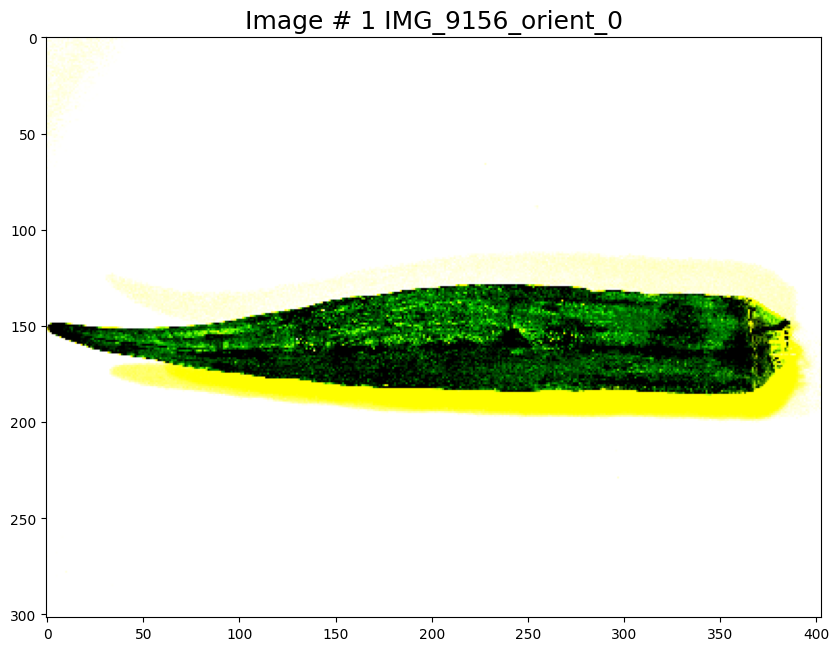

In [14]:
img_tensor = image.squeeze(0)
img_nparray = img_tensor.permute(1, 2, 0).numpy()

plt.figure(figsize=(10,10))
img_name = dataset.ids[iter_cnt - 1]
plt.title(f"Image # {iter_cnt} {img_name}", fontsize=18)
plt.imshow(img_nparray)

In [15]:
# model.eval()
mask_pred = model(image)



# true_mask = torch.flip(vert_flipped_mask, dims=[1])
# neg_mask = ~true_mask

In [ ]:
print(mask_pred['out'].shape)
print(image.shape)

torch.Size([1, 1, 302, 403])
torch.Size([1, 3, 302, 403])


tensor([ -7.9811,  -7.9811,  -7.9811,  -7.9811,  -7.9811,  -7.9811,  -7.9811,
         -7.9811,  -7.9940,  -8.0174,  -8.0408,  -8.0642,  -8.0876,  -8.1110,
         -8.1344,  -8.1578,  -8.1812,  -8.2046,  -8.2280,  -8.2514,  -8.2748,
         -8.2982,  -8.3216,  -8.3450,  -8.3859,  -8.4358,  -8.4858,  -8.5357,
         -8.5857,  -8.6357,  -8.6856,  -8.7356,  -8.7855,  -8.8355,  -8.8855,
         -8.9354,  -8.9854,  -9.0354,  -9.0853,  -9.1353,  -9.1147,  -9.0721,
         -9.0296,  -8.9871,  -8.9445,  -8.9020,  -8.8595,  -8.8170,  -8.7744,
         -8.7319,  -8.6894,  -8.6469,  -8.6043,  -8.5618,  -8.5193,  -8.4767,
         -8.4969,  -8.5266,  -8.5563,  -8.5860,  -8.6157,  -8.6454,  -8.6751,
         -8.7048,  -8.7345,  -8.7642,  -8.7939,  -8.8236,  -8.8533,  -8.8830,
         -8.9127,  -8.9424,  -8.9596,  -8.9765,  -8.9934,  -9.0103,  -9.0272,
         -9.0441,  -9.0610,  -9.0778,  -9.0947,  -9.1116,  -9.1285,  -9.1454,
         -9.1623,  -9.1792,  -9.1961,  -9.1979,  -9.0241,  -8.85

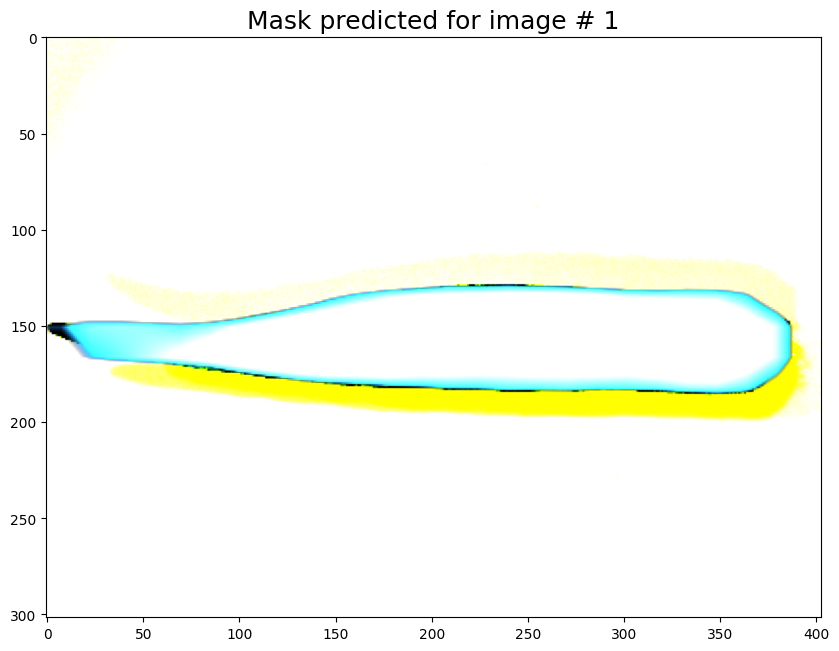

In [16]:
def show_image_with_mask(image, mask, iter_cnt):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask( mask, plt.gca())
    plt.title(f"Mask predicted for image # {iter_cnt}", fontsize=18)
    # plt.axis('off')
    plt.show()

print(mask_pred['out'][0,0,:,200])
show_image_with_mask(img_nparray, mask_pred['out'].detach(), iter_cnt)

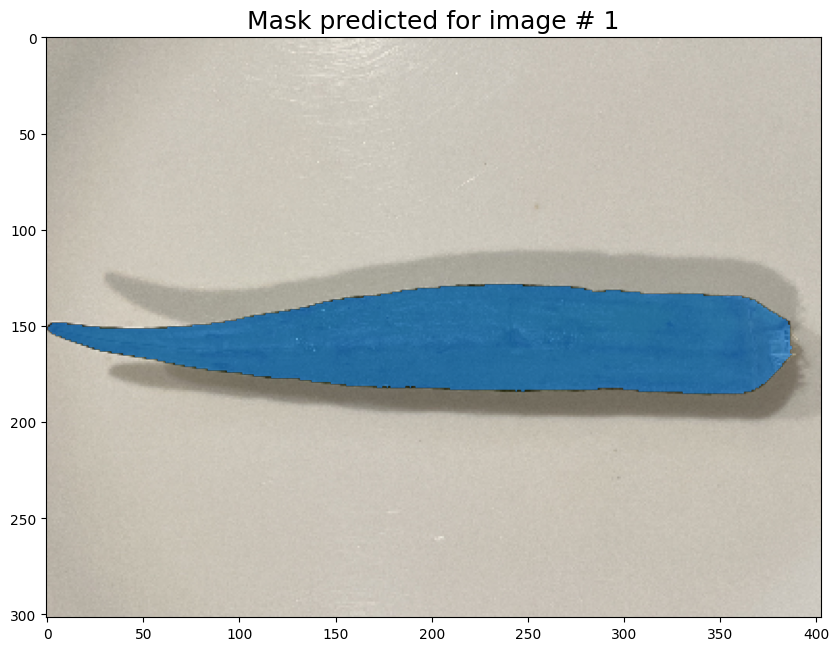

In [ ]:
show_image_with_mask(img_nparray, target, iter_cnt)

In [ ]:
#x1 = torch.rand(4,).float()
#y1 = torch.randint(0,2, (4,)).float()
x1 = torch.randn(3, 1, 4, 4, requires_grad=True).float()
y1 = (torch.rand(3, 4, 4) > 0.5).float()
y1 = y1.unsqueeze(1)
print("x1 : ",x1.dtype, x1.shape)
print("y1 : ",y1.dtype, y1.shape)
print("x1 = ", x1)

# Directly calling nn.BCEWithLogitsLoss throws error
# l = nn.BCEWithLogitsLoss(x1, y1)
# RuntimeError: Boolean value of Tensor with more than one value is ambiguous
# so call thru functor

loss_fn1 = nn.BCEWithLogitsLoss()
loss_fn2 = nn.MSELoss()
l1 = loss_fn1(x1, y1)
l2 = loss_fn2(x1, y1)
print(l1)
print(l2)


x1 :  torch.float32 torch.Size([3, 1, 4, 4])
y1 :  torch.float32 torch.Size([3, 1, 4, 4])
x1 =  tensor([[[[ 0.6142,  0.6082,  0.3920, -0.5436],
          [-0.4809,  1.0770, -1.0921, -0.7398],
          [ 1.0926, -1.2116,  0.1297, -1.4881],
          [ 0.0507,  0.4029,  0.7711,  1.5993]]],


        [[[-0.3707, -0.3030,  1.2893, -1.4989],
          [ 0.1805,  0.9125, -0.0664, -0.5133],
          [ 1.0514,  0.0910, -0.8968,  0.6882],
          [ 0.5312, -0.6457, -1.2694,  0.3856]]],


        [[[ 0.9158,  1.6254, -0.1298,  0.8346],
          [ 0.3507, -0.4914,  0.3189, -0.7993],
          [ 0.5879,  1.6534,  0.4615,  0.0746],
          [ 1.7241,  1.0173,  0.0520,  0.2988]]]], requires_grad=True)
tensor(0.7616, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.0497, grad_fn=<MseLossBackward0>)


In [ ]:
# Generate random tensors
x = torch.randn(3, 1, 4, 4).float()
y = (torch.rand(3, 4, 4) > 0.5).float()

# Reshape y to have the same shape as x
y = y.unsqueeze(1)

# Define the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Compute the loss
loss = loss_fn(x, y)

print(loss)

tensor(0.8836)
